In [ ]:
from random import choices, randint, choice
import numpy as np
import math
import pymc3 as pm
import matplotlib.pyplot as plt
import csv
from google.colab import files 

# State Space + Utility Definitions

In [ ]:
# General grid class with utilities and transitions

class Grid:
  def __init__(self,
               blue_reward_cells, # list/dict: of blue reward cells (ex. [0, 1])
               yellow_reward_cells, # list/dict: of yellow reward cells (ex. [9, 10])
               num_cells, # int: number of cells in the grid 
               starting_cells, # list of blue/yellow starting cells (ex, [4, 6])
               cell_transition_func): # func: transition function (cell, action) --> cell
    self.blue_reward_cells = blue_reward_cells
    self.yellow_reward_cells = yellow_reward_cells
    self.num_cells = num_cells
    self.cell_transition = cell_transition_func

    self.state_transitions = {} # call self.all_state_transitions() to update
    self.state_transitions_0 = {}
          
    self.actions = {'RIGHT', 'LEFT', 'UP', 'DOWN', 'WAIT'}
    all_actions = []
    for a1 in self.actions:
      for a2 in self.actions:
        all_actions.append((a1, a2))

    self.all_actions = all_actions
  
  # State transition function: state_transitions[state][action_pair] = [next_states], 
  # next_states being 1 or 2 states (if there is a fight)
  # Returns updated self.state_transitions dictionary 
  def all_state_transitions(self, level):
    if level == 0:
      for i in range(self.num_cells):
        self.state_transitions_0[(i, None)] = {}
        for action in self.actions:
          (next_i, next_j, collide) = self.state_transition((i, None), action, None)
          if next_i == None:
            self.state_transitions_0[(i, None)][action] = [(None, None)]
          self.state_transitions_0[(i, None)][(action, None)] = [(next_i, next_j)]
      return self.state_transitions_0
        
    elif level == 1:
      for i in range(self.num_cells): 
        for j in range(self.num_cells):
          if i != j: # cannot occupy same cell
            self.state_transitions[(i, j)] = {}
            for action in self.all_actions:
              (next_i, next_j, collide) = self.state_transition((i, j), action[0], action[1])
              if next_i == None or next_j == None:
                self.state_transitions[(i, j)][action] = [(None, None)]
              elif not collide[0]:
                self.state_transitions[(i, j)][action] = [(next_i, next_j)]
              else: # collision occured
                  self.state_transitions[(i, j)][action] = [(next_i, next_j), collide[1]]
      return self.state_transitions

  # Utility function: takes in new state, previous state, and two actions, 
  # and list/set of reward cells for blue / yellow player, and cell transition 
  # function for this grid.
  # Outputs a tuple of two utilities (U1, U2), unless finding level-0 utility 
  # for lone player in the grid, in which case we set a2 = None
  # Utility of reward = 10, any attempted movement/wait = -1
  def get_utility(self, s_new, s, a1, a2, player = None):
    blue_new, yellow_new = s_new
    blue_old, yellow_old = s

    # calculate U1
    if blue_new in self.blue_reward_cells:
      U1 = 10
    else:
      U1 = -1
    
    # return level-0 utility for lone player
    if a2 == None:
      if player == "Blue":
        return U1 
      elif player == "Yellow":
        if yellow_new in self.yellow_reward_cells:
          U2 = 10
        else:
          U2 = -1
        return U2
    else: # if two players, calculate U2
      if yellow_new in self.yellow_reward_cells:
        U2 = 10
      else:
        U2 = -1

    blue_intended = self.cell_transition(blue_old, a1)
    yellow_intended = self.cell_transition(yellow_old, a2)

    # Illegal moves:
    # if players try to move into the same cell (one succeeds) = both lose 1 point
    # if player tries to move onto stationary player = lose 1 point
    if blue_intended != None and yellow_intended != None: 
      if blue_intended == yellow_intended:
        if a1 != 'WAIT':
          U1 = U1-1
        if a2 != 'WAIT':
          U2 = U2-1

      # if players try to swap spots (bounce back) = both lose 1 point
      elif ((blue_intended == yellow_old) and (yellow_intended == blue_old)):
        U1 = U1-1 
        U2 = U2-1
    
    return (U1, U2)

  # general_utility is a general utility function that calculates the joint utility
  # given w (weight on U1), previous state s, new state s_new, actions a1 and a2, 
  # and utility function u_func for this specific board used
  def general_utility(self, w, s_new, s, a1, a2):
    U1, U2 = self.get_utility(s_new, s, a1, a2)
    return w*U1 + (1-w)*U2

  # State transition function takes the current state (Blue, Yellow), 
  # the given actions, and returns the new state. If two players try to go to 
  # the same cell, they have a 50% chance of success. 
  def state_transition(self, s, a1, a2): 
    collide = (False, None) # (whether a collision occured, the other possible state if a collision occured)
    
    blue_state, yellow_state = s

    if blue_state in self.blue_reward_cells or yellow_state in self.yellow_reward_cells:
      return (None, None, collide)
    
    # level-0 state transition
    if a2 == None:
      next_state = self.cell_transition(s[0], a1)
      if next_state == None:
        next_state = s[0]
      return (next_state, None, collide) 

    blue_next = self.cell_transition(blue_state, a1)
    yellow_next = self.cell_transition(yellow_state, a2)

    # check for impossible moves
    if blue_next == None or yellow_next == None:
      blue_next = blue_state
      yellow_next = yellow_state

    if blue_next == yellow_next:
      if a1 == "WAIT" or a2 == "WAIT":
        blue_next = blue_state
        yellow_next = yellow_state
      else: # check if players try to move to the same cell
        random_flip = randint(0, 1) # 0 = blue wins, 1 = yellow wins
        if random_flip == 0: 
          collide = (True, (blue_state, yellow_next))
          yellow_next = yellow_state
        else:
          collide = (True, (blue_next, yellow_state))
          blue_next = blue_state

    return (blue_next, yellow_next, collide)
  
  # Function that takes in the new state, current state, current action(s), and level of 
  # the player and returns the transition probability for the future state
  # given the current state and actions
  def transition_probabilities(self, s_new, s, a1, a2, player_level = 1):

    # level-0 player (considering moves of only one player)
    if player_level == 0:
      next_state = self.cell_transition(s, a1)
      if next_state == s_new[0]: # always place state in index 0, ex. (3, None)
        return 1
      else:
        return 0
    
    # level-1 player (considering moves of both players)
    blue, yellow = s
    blue_new, yellow_new = s_new
    blue_intended, yellow_intended, collide = self.state_transition(s, a1, a2)

    # check if either player reached end state
    if blue in self.blue_reward_cells or yellow in self.yellow_reward_cells:
      return 0

    # players did not attempt to occupy the same spot
    if not collide[0]:
      if blue_new == blue_intended and yellow_new == yellow_intended:
        return 1
      else:
        return 0
    else: # players attempted to occupy the same spot
      if ((blue_new == blue_intended and yellow_new == yellow_intended) or (blue_new, yellow_new) == collide[1]):
        return 0.5
      else: 
        return 0      


## GRID 1

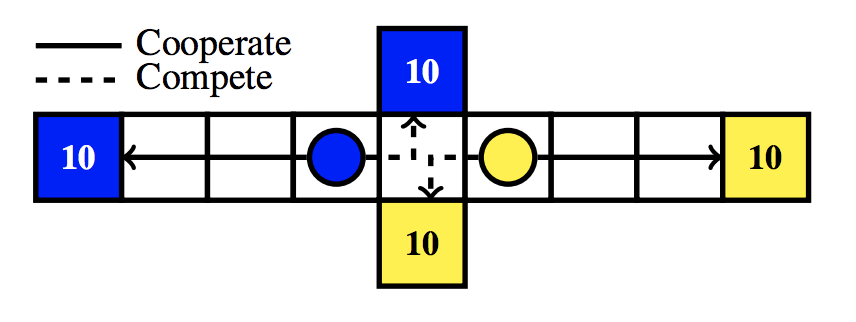

In [ ]:
# State Space -- defined by (Blue, Yellow) grid cells

# Each Grid labeled by 
# [ ,  ,  ,  , 0,  ,  ,  ,  ]
# [1, 2, 3, 4, 5, 6, 7, 8, 9]
# [ ,  ,  ,  , 10  ,  ,  ,  ]

# initial state is (4, 6) (Blue, Yellow)

In [ ]:
# Helper function for cell transition -- given a current cell and an action,
# returns the next cell assuming no obstacles. Returns None for an illegal move. 
def cell_transition_grid1(cell, action):
  
  if action == 'RIGHT':
    if cell in range(1, 9):
      return cell + 1

  elif action == 'LEFT':
    if cell in range(2, 10):
      return cell - 1
  
  elif action == 'UP':
    if cell in {5, 10}:
      return cell - 5

  elif action == 'DOWN':
    if cell in {0, 5}:
      return cell + 5

  elif action == 'WAIT': 
    return cell
  
  return None 

def cell_to_row_col_pair1(cell):
  if cell == 0: return (0, 4)
  elif cell > 0 and cell < 10: return (1, cell-1)
  elif cell == 10: return (2, 4)
  else: return None

def start_state_grid1():
  return (4, 6)


## GRID 2

In [ ]:
# State Space -- defined by (Blue, Yellow) grid cells

# Each Grid labeled by 
# [ , 0,  ]
# [1, 2, 3]
# [4, 5, 6]
# [7, 8, 9]
# [ , 10,  ]

# initial state is (4, 6) (Blue, Yellow)
# Blue goal at 0, yellow goal at 10

In [ ]:
# Helper function for cell transition -- given a current cell and an action,
# returns the next cell assuming no obstacles. Returns None for an illegal move. 
def cell_transition_grid2(cell, action):
  
  if action == 'RIGHT':
    if cell in {1, 2, 4, 5, 7, 8}:
      return cell + 1

  elif action == 'LEFT':
    if cell in {2, 3, 5, 6, 8, 9}:
      return cell - 1
  
  elif action == 'UP':
    if cell in {4, 5, 6, 7, 8, 9}:
      return cell - 3
    elif cell in {10, 2}:
      return cell - 2

  elif action == 'DOWN':
    if cell in {1, 2, 3, 4, 5, 6}:
      return cell + 3
    elif cell in {0, 8}:
      return cell + 2

  elif action == 'WAIT': 
    return cell
  
  return None 


def cell_to_row_col_pair2(cell):
  if cell == 0: return (0, 1)
  elif cell > 0 and cell <= 3: return (1, cell-1)
  elif cell > 3 and cell <= 6: return (2, cell-4)
  elif cell > 6 and cell <= 9: return (3, cell-7)
  elif cell == 10: return (4, 1)
  else: return None

def start_state_grid2():
  return (4, 6)

# CoopAgent

In [ ]:
class CoopAgent:
  def __init__(self, 
               grid, # object: instance of grid class 
               beta, # float: softmax that determines how noisy the transition probabilities are
               w): # float: weight for player 1's utility

    state_size = grid.num_cells 
    action_size = 5 # four directions + wait

    # pi dictionary, self.pi[state][(a1, a2)] = P(a1, a2 | s)
    self.pi_blue = {}
    self.pi_yellow = {}
    self.pi_both = {}

    # q dictionary, self.q[state][action_pair] = value
    self.q_blue = {}
    self.q_yellow = {}

    # create q and pi dictionaries
    for i in range(state_size): 
      for j in range(state_size):
        if i != j: # cannot occupy same cell
          self.q_blue[(i, j)] = {}
          self.q_yellow[(i, j)] = {}
          dict1 = {}
          dict2 = {}
          dict3 = {}
          for a1 in grid.actions:
            for a2 in grid.actions:
              dict1[(a1, a2)] = 0
              dict2[(a1, a2)] = 0
              dict3[(a1, a2)] = 0
              self.q_blue[(i, j)][(a1, a2)] = 0
              self.q_yellow[(i, j)][(a1, a2)] = 0
          self.pi_blue[(i, j)] = dict1
          self.pi_yellow[(i, j)] = dict2
          self.pi_both[(i, j)] = dict3

    self.beta = beta
    self.grid = grid
    self.w = w

    self.all_actions = grid.all_actions
    self.state_transitions = grid.all_state_transitions(1)

  # Function that updates Q and Pi based off general utility
  def train(self, player, discount_factor = 0.9, epsilon = .1):
    continue_update = True

    # while there are still Q values left to update, continue
    while continue_update: 
      continue_update = False
      for s in self.state_transitions: # all_states from GRID: dict with key = state
                                       # self.state_transitions[s][action_pair] = [next_states]
        for act_pair in self.all_actions:
          new_q_value = 0
          a1, a2 = act_pair
          # condition - if a1 and a2 match up with pi_0
          next_states = self.state_transitions[s][act_pair]

          for s_next in next_states:
            if s_next != (None, None):
              utility = self.grid.general_utility(self.w, s_next, s, a1, a2)
              transition = self.grid.transition_probabilities(s_next, s, a1, a2, 1)

              if player == "Blue":
                max_q_value = max(self.q_blue[s_next].values())
                new_q_value += transition*(utility + discount_factor*max_q_value)
              elif player == "Yellow":
                max_q_value = max(self.q_yellow[s_next].values())
                new_q_value += transition*(utility + discount_factor*max_q_value)

          if player == "Blue":
            old_q_value = self.q_blue[s][act_pair]
            self.q_blue[s][act_pair] = new_q_value
            if abs(old_q_value - new_q_value) > epsilon:
              continue_update = True

          elif player == "Yellow":
            old_q_value = self.q_yellow[s][act_pair]
            self.q_yellow[s][act_pair] = new_q_value
            if abs(old_q_value - new_q_value) > epsilon:
              continue_update = True

        # Softmax function that uses self.q_blue and self.q_yellow to find self.pi_blue and self.pi_yellow
        # self.pi_blue / self.pi_yellow should take a state, and output an action by sampling the distribution 
        # and using the given beta value. For coop, might also have to do something related to taking marginals. 
        right_sum = 0; left_sum = 0; up_sum = 0; down_sum = 0; wait_sum = 0 # initialize all marginal values
        if player == "Blue":
          values = np.array([]) # list of softmax values
          for act_pair in self.all_actions: 
            blue_move = act_pair[0]
            if blue_move == "RIGHT":
              right_sum += math.exp(self.beta*self.q_blue[s][act_pair])
            elif blue_move == "LEFT":
              left_sum += math.exp(self.beta*self.q_blue[s][act_pair])
            elif blue_move == "UP":
              up_sum += math.exp(self.beta*self.q_blue[s][act_pair])
            elif blue_move == "DOWN":
              down_sum += math.exp(self.beta*self.q_blue[s][act_pair])
            elif blue_move == "WAIT":
              wait_sum += math.exp(self.beta*self.q_blue[s][act_pair])
          values = np.array([right_sum, left_sum, up_sum, down_sum, wait_sum])
          values = values/sum(values) # normalize
          self.pi_blue[s] = values
          
        elif player == "Yellow":
          values = np.array([]) # list of softmax values
          for act_pair in self.all_actions: 
            yellow_move = act_pair[1]
            if yellow_move == "RIGHT":
              right_sum += math.exp(self.beta*self.q_yellow[s][act_pair])
            elif yellow_move == "LEFT":
              left_sum += math.exp(self.beta*self.q_yellow[s][act_pair])
            elif yellow_move == "UP":
              up_sum += math.exp(self.beta*self.q_yellow[s][act_pair])
            elif yellow_move == "DOWN":
              down_sum += math.exp(self.beta*self.q_yellow[s][act_pair])
            elif yellow_move == "WAIT":
              wait_sum += math.exp(self.beta*self.q_yellow[s][act_pair])
          values = np.array([right_sum, left_sum, up_sum, down_sum, wait_sum])
          values = values/sum(values) # normalize
          self.pi_yellow[s] = values
        
        # update self.pi_both with joint probability distributions
        act_pair_sums = []
        for act_pair in self.all_actions:
          if player == "Blue":
            act_pair_sums.append(math.exp(self.beta*self.q_blue[s][act_pair]))
          elif player == "Yellow":
            act_pair_sums.append(math.exp(self.beta*self.q_yellow[s][act_pair]))
        values_both = np.array(act_pair_sums)
        values_both = values_both/sum(values_both)
        self.pi_both[s] = values_both
      
  # Function that takes in current state and returns the best action for both players
  def get_both_actions(self, s):
    distributions = self.pi_both[s]
    action = choices(self.all_actions, distributions)
    return action 
        
  # Function that takes in current state and player and returns the best action for each player individually
  def get_action(self, s, player): 
    actions = ["RIGHT", "LEFT", "UP", "DOWN", "WAIT"]
    if player == "Blue":
      distributions = self.pi_blue[s] 
      action = choices(actions, distributions)
      return action
    elif player == "Yellow":
      distributions = self.pi_yellow[s] 
      action = choices(actions, distributions)
      return action

# CompeteAgent


In [ ]:
class CompeteAgent:
  def __init__(self, 
               grid, # object: instance of grid class 
               beta): # float: softmax that determines how noisy the transition probabilities are

    state_size = grid.num_cells # state size level-0 
    action_size = 5 # four directions + wait

    # pi dictionary, self.pi[state][(a1, a2)] = P(a1, a2 | s)
    self.pi_blue = {}
    self.pi_yellow = {}
    self.pi_blue_0 = {}
    self.pi_yellow_0 = {}

    # q dictionary, self.q[state][action_pair] = value
    self.q_blue = {}
    self.q_yellow = {}
    self.q_blue_0 = {}
    self.q_yellow_0 = {}

    # pi_0, q_0 dictionary 
    for i in range(state_size):
      self.q_blue_0[(i, None)] = {}
      self.q_yellow_0[(i, None)] = {}
      for a1 in grid.actions:
        self.q_blue_0[(i, None)][(a1, None)] = 0
        self.q_yellow_0[(i, None)][(a1, None)] = 0
      self.pi_blue_0[(i, None)] = [0]*5
      self.pi_yellow_0[(i, None)] = [0]*5

   # pi and q dictionary 
    for i in range(state_size): 
      for j in range(state_size):
        if i != j: # cannot occupy same cell
          self.q_blue[(i, j)] = {}
          self.q_yellow[(i, j)] = {}
          for a1 in grid.actions:
            for a2 in grid.actions:
              self.q_blue[(i, j)][(a1, a2)] = 0
              self.q_yellow[(i, j)][(a1, a2)] = 0
          self.pi_blue[(i, j)] = [0]*25
          self.pi_yellow[(i, j)] = [0]*25

    self.beta = beta
    self.grid = grid

    self.all_actions = grid.all_actions
    self.state_transitions = grid.all_state_transitions(1)
    self.state_transitions_0 = grid.all_state_transitions(0)

  def train_0(self, player, discount_factor = 0.9, epsilon = 0.1):
    continue_update = True

    while continue_update: 
      continue_update = False

      for s in self.state_transitions_0:
        for action in self.grid.actions:
          new_q_value = 0
          act_pair = (action, None)
          next_states = self.state_transitions_0[s][act_pair]
    

          for s_next in next_states:
            if s_next != (None, None):
              utility = self.grid.get_utility(s_next, s, action, None, player)
              transition = self.grid.transition_probabilities(s_next, s, action, None, 0)

              if player == "Blue":
                max_q_value = max(self.q_blue_0[s_next].values())
                new_q_value += transition*(utility + discount_factor*max_q_value)
              elif player == "Yellow":
                max_q_value = max(self.q_yellow_0[s_next].values())
                new_q_value += transition*(utility + discount_factor*max_q_value)

          if player == "Blue":
            old_q_value = self.q_blue_0[s][act_pair]
            self.q_blue_0[s][act_pair] = new_q_value
            if abs(old_q_value - new_q_value) > epsilon:
              continue_update = True

          elif player == "Yellow":
            old_q_value = self.q_yellow_0[s][act_pair]
            self.q_yellow_0[s][act_pair] = new_q_value
            if abs(old_q_value - new_q_value) > epsilon:
                continue_update = True

        right_sum = 0; left_sum = 0; up_sum = 0; down_sum = 0; wait_sum = 0 # initialize all marginal values
        if player == "Blue":
          values = np.array([]) # list of softmax values
          for action in self.grid.actions: 
            act_pair = (action, None)
            if action == "RIGHT":
              right_sum += math.exp(self.beta*self.q_blue_0[s][act_pair])
            elif action == "LEFT":
              left_sum += math.exp(self.beta*self.q_blue_0[s][act_pair])
            elif action == "UP":
              up_sum += math.exp(self.beta*self.q_blue_0[s][act_pair])
            elif action == "DOWN":
              down_sum += math.exp(self.beta*self.q_blue_0[s][act_pair])
            elif action == "WAIT":
              wait_sum += math.exp(self.beta*self.q_blue_0[s][act_pair])
          values = np.array([right_sum, left_sum, up_sum, down_sum, wait_sum])
          values = values/sum(values) # normalize
          self.pi_blue_0[s] = values
          
        elif player == "Yellow":
          values = np.array([]) # list of softmax values
          for action in self.grid.actions: 
            act_pair = (action, None)
            if action == "RIGHT":
              right_sum += math.exp(self.beta*self.q_yellow_0[s][act_pair])
            elif action == "LEFT":
              left_sum += math.exp(self.beta*self.q_yellow_0[s][act_pair])
            elif action == "UP":
              up_sum += math.exp(self.beta*self.q_yellow_0[s][act_pair])
            elif action == "DOWN":
              down_sum += math.exp(self.beta*self.q_yellow_0[s][act_pair])
            elif action == "WAIT":
              wait_sum += math.exp(self.beta*self.q_yellow_0[s][act_pair])
          values = np.array([right_sum, left_sum, up_sum, down_sum, wait_sum])
          values = values/sum(values) # normalize
          self.pi_yellow_0[s] = values

  def get_action_0(self, s, player): 
    actions = ["RIGHT", "LEFT", "UP", "DOWN", "WAIT"]
    if player == "Blue":
      distributions = self.pi_blue_0[s] 
      action = choices(actions, distributions)
      return action[0]
    elif player == "Yellow":
      distributions = self.pi_yellow_0[s] 
      action = choices(actions, distributions)
      return action[0]

  # Function that updates Q and Pi based off general utility
  def train(self, player, discount_factor = 0.9, epsilon = .1):
    if player == "Blue": 
      self.train_0("Yellow", discount_factor, epsilon)
    else:
      self.train_0("Blue", discount_factor, epsilon)

    continue_update = True

    # while there are still Q values left to update, continue
    while continue_update: 
      continue_update = False 
      for s in self.state_transitions: # all_states from GRID: dict with key = state
                                       # self.state_transitions[s][action_pair] = [next_states]
        for action in self.grid.actions:
          new_q_value = 0
          if player == "Blue":
            a2 = self.get_action_0((s[1], None), "Yellow")
            act_pair = (action, a2)
          elif player == "Yellow":
            a1 = self.get_action_0((s[0], None), "Blue")
            act_pair = (a1, action)

          # condition - if a1 and a2 match up with pi_0
          next_states = self.state_transitions[s][act_pair]

          for s_next in next_states:
            if s_next != (None, None):
              utility = self.grid.get_utility(s_next, s, act_pair[0], act_pair[1], player)
              transition = self.grid.transition_probabilities(s_next, s, act_pair[0], act_pair[1], 1)

              if player == "Blue":
                max_q_value = max(self.q_blue[s_next].values())
                new_q_value += transition*(utility[0] + discount_factor*max_q_value)
              elif player == "Yellow":
                max_q_value = max(self.q_yellow[s_next].values())
                new_q_value += transition*(utility[1] + discount_factor*max_q_value)

          if player == "Blue":
            old_q_value = self.q_blue[s][act_pair]
            self.q_blue[s][act_pair] = new_q_value
            if abs(old_q_value - new_q_value) > epsilon:
              continue_update = True

          elif player == "Yellow":
            old_q_value = self.q_yellow[s][act_pair]
            self.q_yellow[s][act_pair] = new_q_value
            if abs(old_q_value - new_q_value) > epsilon:
              continue_update = True

        # Softmax function that uses self.q_blue and self.q_yellow to find self.pi_blue and self.pi_yellow
        # self.pi_blue / self.pi_yellow should take a state, and output an action by sampling the distribution 
        # and using the given beta value. For coop, might also have to do something related to taking marginals. 
        right_sum = 0; left_sum = 0; up_sum = 0; down_sum = 0; wait_sum = 0 # initialize all marginal values
        if player == "Blue":
          values = np.array([]) # list of softmax values
          for act_pair in self.all_actions: 
            blue_move = act_pair[0]
            if blue_move == "RIGHT":
              right_sum += math.exp(self.beta*self.q_blue[s][act_pair])
            elif blue_move == "LEFT":
              left_sum += math.exp(self.beta*self.q_blue[s][act_pair])
            elif blue_move == "UP":
              up_sum += math.exp(self.beta*self.q_blue[s][act_pair])
            elif blue_move == "DOWN":
              down_sum += math.exp(self.beta*self.q_blue[s][act_pair])
            elif blue_move == "WAIT":
              wait_sum += math.exp(self.beta*self.q_blue[s][act_pair])
          values = np.array([right_sum, left_sum, up_sum, down_sum, wait_sum])
          values = values/sum(values) # normalize
          self.pi_blue[s] = values
          
        elif player == "Yellow":
          values = np.array([]) # list of softmax values
          for act_pair in self.all_actions: 
            yellow_move = act_pair[1]
            if yellow_move == "RIGHT":
              right_sum += math.exp(self.beta*self.q_yellow[s][act_pair])
            elif yellow_move == "LEFT":
              left_sum += math.exp(self.beta*self.q_yellow[s][act_pair])
            elif yellow_move == "UP":
              up_sum += math.exp(self.beta*self.q_yellow[s][act_pair])
            elif yellow_move == "DOWN":
              down_sum += math.exp(self.beta*self.q_yellow[s][act_pair])
            elif yellow_move == "WAIT":
              wait_sum += math.exp(self.beta*self.q_yellow[s][act_pair])
          values = np.array([right_sum, left_sum, up_sum, down_sum, wait_sum])
          values = values/sum(values) # normalize
          self.pi_yellow[s] = values

  # Function that takes in current state and player and returns the best action for each player individually
  def get_action(self, s, player):
    actions = ["RIGHT", "LEFT", "UP", "DOWN", "WAIT"] 
    if player == "Blue":
      distributions = self.pi_blue[s] 
      action = choices(actions, distributions)
      # print(distributions)
      return action
    elif player == "Yellow":
      distributions = self.pi_yellow[s] 
      # print(distributions)
      action = choices(actions, distributions)
      return action


# HinderingAgent

In [ ]:
# CompeteAgent + Utility change
class HinderAgent:
  def __init__(self, 
               grid, # object: instance of grid class 
               beta): # float: softmax that determines how noisy the transition probabilities are

    state_size = grid.num_cells # state size level-0 
    action_size = 5 # four directions + wait

    # pi dictionary, self.pi[state][(a1, a2)] = P(a1, a2 | s)
    self.pi_blue = {}
    self.pi_yellow = {}
    self.pi_blue_0 = {}
    self.pi_yellow_0 = {}

    # q dictionary, self.q[state][action_pair] = value
    self.q_blue = {}
    self.q_yellow = {}
    self.q_blue_0 = {}
    self.q_yellow_0 = {}

    # pi_0, q_0 dictionary 
    for i in range(state_size):
      self.q_blue_0[(i, None)] = {}
      self.q_yellow_0[(i, None)] = {}
      for a1 in grid.actions:
        self.q_blue_0[(i, None)][(a1, None)] = 0
        self.q_yellow_0[(i, None)][(a1, None)] = 0
      self.pi_blue_0[(i, None)] = [0]*5
      self.pi_yellow_0[(i, None)] = [0]*5

   # pi and q dictionary 
    for i in range(state_size): 
      for j in range(state_size):
        if i != j: # cannot occupy same cell
          self.q_blue[(i, j)] = {}
          self.q_yellow[(i, j)] = {}
          for a1 in grid.actions:
            for a2 in grid.actions:
              self.q_blue[(i, j)][(a1, a2)] = 0
              self.q_yellow[(i, j)][(a1, a2)] = 0
          self.pi_blue[(i, j)] = [0]*25
          self.pi_yellow[(i, j)] = [0]*25

    self.beta = beta
    self.grid = grid

    self.all_actions = grid.all_actions
    self.state_transitions = grid.all_state_transitions(1)
    self.state_transitions_0 = grid.all_state_transitions(0)

  def train_0(self, player, discount_factor = 0.9, epsilon = 0.1):
    continue_update = True

    while continue_update: 
      continue_update = False

      for s in self.state_transitions_0:
        for action in self.grid.actions:
          new_q_value = 0
          act_pair = (action, None)
          next_states = self.state_transitions_0[s][act_pair]

          for s_next in next_states:
            if s_next != (None, None):
              utility = self.grid.get_utility(s_next, s, action, None, player)
              transition = self.grid.transition_probabilities(s_next, s, action, None, 0)

              if player == "Blue":
                  max_q_value = max(self.q_blue_0[s_next].values())
                  new_q_value += transition*(utility + discount_factor*max_q_value)
              elif player == "Yellow":
                max_q_value = max(self.q_yellow_0[s_next].values())
                new_q_value += transition*(utility + discount_factor*max_q_value)

          if player == "Blue":
            old_q_value = self.q_blue_0[s][act_pair]
            self.q_blue_0[s][act_pair] = new_q_value
            if abs(old_q_value - new_q_value) > epsilon:
              continue_update = True

          elif player == "Yellow":
            old_q_value = self.q_yellow_0[s][act_pair]
            self.q_yellow_0[s][act_pair] = new_q_value
            if abs(old_q_value - new_q_value) > epsilon:
                continue_update = True

        right_sum = 0; left_sum = 0; up_sum = 0; down_sum = 0; wait_sum = 0 # initialize all marginal values
        if player == "Blue":
          values = np.array([]) # list of softmax values
          for action in self.grid.actions: 
            act_pair = (action, None)
            if action == "RIGHT":
              right_sum += math.exp(self.beta*self.q_blue_0[s][act_pair])
            elif action == "LEFT":
              left_sum += math.exp(self.beta*self.q_blue_0[s][act_pair])
            elif action == "UP":
              up_sum += math.exp(self.beta*self.q_blue_0[s][act_pair])
            elif action == "DOWN":
              down_sum += math.exp(self.beta*self.q_blue_0[s][act_pair])
            elif action == "WAIT":
              wait_sum += math.exp(self.beta*self.q_blue_0[s][act_pair])
          values = np.array([right_sum, left_sum, up_sum, down_sum, wait_sum])
          values = values/sum(values) # normalize
          self.pi_blue_0[s] = values
          
        elif player == "Yellow":
          values = np.array([]) # list of softmax values
          for action in self.grid.actions: 
            act_pair = (action, None)
            if action == "RIGHT":
              right_sum += math.exp(self.beta*self.q_yellow_0[s][act_pair])
            elif action == "LEFT":
              left_sum += math.exp(self.beta*self.q_yellow_0[s][act_pair])
            elif action == "UP":
              up_sum += math.exp(self.beta*self.q_yellow_0[s][act_pair])
            elif action == "DOWN":
              down_sum += math.exp(self.beta*self.q_yellow_0[s][act_pair])
            elif action == "WAIT":
              wait_sum += math.exp(self.beta*self.q_yellow_0[s][act_pair])
          values = np.array([right_sum, left_sum, up_sum, down_sum, wait_sum])
          values = values/sum(values) # normalize
          self.pi_yellow_0[s] = values

  def get_action_0(self, s, player): 
    actions = ["RIGHT", "LEFT", "UP", "DOWN", "WAIT"]
    if player == "Blue":
      distributions = self.pi_blue_0[s] 
      action = choices(actions, distributions)
      return action[0]
    elif player == "Yellow":
      distributions = self.pi_yellow_0[s] 
      action = choices(actions, distributions)
      return action[0]

  # Function that updates Q and Pi based off general utility. 
  # p is specific to hindering agent: describes percentage hindering 
  def train(self, player, p = 0.7, discount_factor = 0.9, epsilon = .1):
    continue_update = True

    # while there are still Q values left to update, continue
    while continue_update: 
      continue_update = False 
      for s in self.state_transitions: # all_states from GRID: dict with key = state
                                       # self.state_transitions[s][action_pair] = [next_states]
        for action in self.grid.actions:
          new_q_value = 0
          if player == "Blue":
            a2 = self.get_action_0((s[1], None), "Yellow")
            act_pair = (action, a2)
          elif player == "Yellow":
            a1 = self.get_action_0((s[0], None), "Blue")
            act_pair = (a1, action)

          # condition - if a1 and a2 match up with pi_0
          next_states = self.state_transitions[s][act_pair]

          for s_next in next_states:
            if s_next != (None, None):
              utility = self.grid.get_utility(s_next, s, act_pair[0], act_pair[1], player)
              transition = self.grid.transition_probabilities(s_next, s, act_pair[0], act_pair[1], 1)

              if player == "Blue":
                max_q_value = max(self.q_blue[s_next].values())
                new_q_value += transition*(utility[0] - p*utility[1] + discount_factor*max_q_value)
              elif player == "Yellow":
                max_q_value = max(self.q_yellow[s_next].values())
                new_q_value += transition*(utility[1] - p*utility[0] + discount_factor*max_q_value)

          if player == "Blue":
            old_q_value = self.q_blue[s][act_pair]
            self.q_blue[s][act_pair] = new_q_value
            if abs(old_q_value - new_q_value) > epsilon:
              continue_update = True

          elif player == "Yellow":
            old_q_value = self.q_yellow[s][act_pair]
            self.q_yellow[s][act_pair] = new_q_value
            if abs(old_q_value - new_q_value) > epsilon:
              continue_update = True

        # Softmax function that uses self.q_blue and self.q_yellow to find self.pi_blue and self.pi_yellow
        # self.pi_blue / self.pi_yellow should take a state, and output an action by sampling the distribution 
        # and using the given beta value. For coop, might also have to do something related to taking marginals. 
        right_sum = 0; left_sum = 0; up_sum = 0; down_sum = 0; wait_sum = 0 # initialize all marginal values
        if player == "Blue":
          values = np.array([]) # list of softmax values
          for act_pair in self.all_actions: 
            blue_move = act_pair[0]
            if blue_move == "RIGHT":
              right_sum += math.exp(self.beta*self.q_blue[s][act_pair])
            elif blue_move == "LEFT":
              left_sum += math.exp(self.beta*self.q_blue[s][act_pair])
            elif blue_move == "UP":
              up_sum += math.exp(self.beta*self.q_blue[s][act_pair])
            elif blue_move == "DOWN":
              down_sum += math.exp(self.beta*self.q_blue[s][act_pair])
            elif blue_move == "WAIT":
              wait_sum += math.exp(self.beta*self.q_blue[s][act_pair])
          values = np.array([right_sum, left_sum, up_sum, down_sum, wait_sum])
          values = values/sum(values) # normalize
          self.pi_blue[s] = values
          
        elif player == "Yellow":
          values = np.array([]) # list of softmax values
          for act_pair in self.all_actions: 
            yellow_move = act_pair[1]
            if yellow_move == "RIGHT":
              right_sum += math.exp(self.beta*self.q_yellow[s][act_pair])
            elif yellow_move == "LEFT":
              left_sum += math.exp(self.beta*self.q_yellow[s][act_pair])
            elif yellow_move == "UP":
              up_sum += math.exp(self.beta*self.q_yellow[s][act_pair])
            elif yellow_move == "DOWN":
              down_sum += math.exp(self.beta*self.q_yellow[s][act_pair])
            elif yellow_move == "WAIT":
              wait_sum += math.exp(self.beta*self.q_yellow[s][act_pair])
          values = np.array([right_sum, left_sum, up_sum, down_sum, wait_sum])
          values = values/sum(values) # normalize
          self.pi_yellow[s] = values

  # Function that takes in current state and player and returns the best action for each player individually
  def get_action(self, s, player):
    actions = ["RIGHT", "LEFT", "UP", "DOWN", "WAIT"] 
    # print(actions)
    if player == "Blue":
      distributions = self.pi_blue[s] 
      action = choices(actions, distributions)
      # print(distributions)
      return action
    elif player == "Yellow":
      distributions = self.pi_yellow[s] 
      action = choices(actions, distributions)
      # print(distributions)
      return action


# Random Agent


In [ ]:
class RandomAgent:
  def __init__(self, 
               grid): # object: instance of grid class 

    # pi dictionary, self.pi[state] = random possible action
    self.pi_blue = {}
    self.pi_yellow = {}

    # possible actions dictionary, self.possible_actions[s] = list of possible actions given that state
    self.possible_blue_actions = {}
    self.possible_yellow_actions = {}

    self.grid = grid
    self.cell_transition = grid.cell_transition

    self.all_actions = grid.all_actions
    self.state_transitions = grid.all_state_transitions(1)

  def update_pi(self, player):
    for s in self.state_transitions:
      blue_cell, yellow_cell = s
      possible_blue_actions = []
      possible_yellow_actions = []
      for (a1, a2) in self.all_actions:
        blue_next = self.cell_transition(blue_cell, a1)
        yellow_next = self.cell_transition(yellow_cell, a2)
      
        if blue_next != None and a1 not in possible_blue_actions:
          possible_blue_actions.append(a1)
        if yellow_next != None and a2 not in possible_yellow_actions:
          possible_yellow_actions.append(a2)
      
      self.possible_blue_actions[s] = possible_blue_actions
      self.possible_yellow_actions[s] = possible_yellow_actions

      blue_length = len(self.possible_blue_actions[s])*1.5
      yellow_length = len(self.possible_yellow_actions[s])*1.5

      values_blue = []
      values_yellow = []

      if "RIGHT" in self.possible_blue_actions[s]: values_blue.append(1/blue_length)
      else: values_blue.append(0)
      if "LEFT" in self.possible_blue_actions[s]: values_blue.append(1/blue_length)
      else: values_blue.append(0)
      if "UP" in self.possible_blue_actions[s]: values_blue.append(1/blue_length)
      else: values_blue.append(0)
      if "DOWN" in self.possible_blue_actions[s]: values_blue.append(1/blue_length)
      else: values_blue.append(0)
      if "WAIT" in self.possible_blue_actions[s]: values_blue.append(1/blue_length)
      else: values_blue.append(0)

      if "RIGHT" in self.possible_yellow_actions[s]: values_yellow.append(1/yellow_length)
      else: values_yellow.append(0)
      if "LEFT" in self.possible_yellow_actions[s]: values_yellow.append(1/yellow_length)
      else: values_yellow.append(0)
      if "UP" in self.possible_yellow_actions[s]: values_yellow.append(1/yellow_length)
      else: values_yellow.append(0)
      if "DOWN" in self.possible_yellow_actions[s]: values_yellow.append(1/yellow_length)
      else: values_yellow.append(0)
      if "WAIT" in self.possible_yellow_actions[s]: values_yellow.append(1/yellow_length)
      else: values_yellow.append(0)
      
      self.pi_blue[s] = values_blue
      self.pi_yellow[s] = values_yellow

  # Function that takes in current state and player and returns the best action for each player individually
  def get_action(self, s, player): 
    actions = ["RIGHT", "LEFT", "UP", "DOWN", "WAIT"]
    if player == "Blue":
      # return choices(self.grid.actions,  self.pi_blue[s])
      return choices(actions, self.pi_blue[s])
    elif player == "Yellow":
      # return choices(self.grid.actions,  self.pi_yellow[s])
      return choices(actions, self.pi_yellow[s])

  def get_both_actions(self, s): 
    blue = choices(actions, self.pi_blue[s])
    # blue = choices(self.grid.actions,  self.pi_blue[s])
    yellow = choices(actions, self.pi_yellow[s])
    # yellow = choices(self.grid.actions,  self.pi_yellow[s])
    return (blue, yellow)

# Helper Functions

## Text File to Dataframe

In [ ]:
uploaded = files.upload()

KeyboardInterrupt: ignored

In [ ]:
# function that reads .txt file and converts file to the input data format [((s1, s2), (a1, a2))] to feed into the model
def read_data():
  filename = "collected_data.txt"
  data = open(filename, 'r')
  rows = [(line.strip()) for line in data]

  grid1_data = []
  grid2_data = []
  all_data = []
  for i in range(0, 432, 9):
    grid = int(rows[i+1][-1])

    p1_moves = rows[i+3][4:len(rows[i+3])-1]
    p2_moves = rows[i+4][4:len(rows[i+4])-1]

    p1_moves = p1_moves.split(', ')
    p2_moves = p2_moves.split(', ')

    p1_states = rows[i+6][4:len(rows[i+6])-1]
    p2_states = rows[i+7][4:len(rows[i+7])-1]

    p1_states = p1_states.split(', ') 
    p2_states = p2_states.split(', ')

    sub_data = []
    for i in range(len(p1_moves)):
      add = ((int(p1_states[i]), int(p2_states[i])), (p1_moves[i][1:-1], p2_moves[i][1:-1]))
      sub_data.append(add)

    final = ((int(p1_states[-1]), int(p2_states[-1])), (None, None))
    sub_data.append(final)

    all_data.append((sub_data, grid))
    
    if grid == 1:
      grid1_data.append(sub_data)
    elif grid == 2:
      grid2_data.append(sub_data)

  return all_data


# Testing


In [ ]:
# Test CoopAgent
grid1 = Grid([0, 1], [9, 10], 11, [4, 6], cell_transition_grid1)
coop = CoopAgent(grid1, 4, 0.5)
coop.train("Blue")
coop.train("Yellow")

grid2 = Grid([0], [10], 11, [4, 6], cell_transition_grid2)
coop2 = CoopAgent(grid2, 4, 0.5)
coop2.train("Blue")
coop2.train("Yellow")

action = coop.get_both_actions((4, 6))
action2 = coop.get_action((4, 6), "Blue")
action3 = coop.get_action((4, 6), "Yellow")
print(action, action2, action3)

action = coop2.get_both_actions((4, 6))
action2 = coop2.get_action((4, 6), "Blue")
action3 = coop2.get_action((4, 6), "Yellow")
print(action, action2, action3)

In [ ]:
# Test CompeteAgent
grid1 = Grid([0, 1], [9, 10], 11, [4, 6], cell_transition_grid1)
compete = CompeteAgent(grid1, 4)
# compete.train_0("Blue")
compete.train("Blue")
# compete.train_0("Yellow")
compete.train("Yellow")

grid2 = Grid([0], [10], 11, [4, 6], cell_transition_grid2)
compete2 = CompeteAgent(grid2, 4)
#compete2.train_0("Blue")
compete2.train("Blue", epsilon=0.001)
#compete2.train_0("Yellow")
compete2.train("Yellow", epsilon=0.001)

action = compete.get_action((5, 6), "Blue")
action2 = compete.get_action((4, 5), "Yellow")
print(action, action2)

action = compete2.get_action((4, 6), "Blue")
action2 = compete2.get_action((4, 6), "Yellow")
print(action, action2)

In [ ]:
# Test HinderAgent
grid1 = Grid([0, 1], [9, 10], 11, [4, 6], cell_transition_grid1)
grid2 = Grid([0], [10], 11, [4, 6], cell_transition_grid2)

eps = 0.1
discount_factor = 0.95

hinder = HinderAgent(grid1, 4)
hinder.train_0("Yellow", epsilon=eps)
hinder.train("Blue", p=0.9, epsilon=eps)
hinder.train_0("Blue", epsilon=eps)
hinder.train("Yellow", p=5, epsilon=eps)

hinder2 = HinderAgent(grid2, 4)
hinder2.train_0("Yellow", epsilon=eps)
hinder2.train("Blue", p=1, epsilon=eps)
hinder2.train_0("Blue", epsilon=eps)
hinder2.train("Yellow", p=5, epsilon=eps)

action2 = hinder.get_action((4, 6), "Blue")
action3 = hinder.get_action((4, 6), "Yellow")
print(action2, action3)

action2 = hinder2.get_action((5, 9), "Blue")
action3 = hinder2.get_action((1, 5), "Yellow")
print(action2, action3)

In [ ]:
# Test RandomAgent
grid1 = Grid([0, 1], [9, 10], 11, [4, 6], cell_transition_grid1)
grid2 = Grid([0], [10], 11, [4, 6], cell_transition_grid2)

random1 = RandomAgent(grid1)
random2 = RandomAgent(grid2)

random1.update_pi("Blue")
random2.update_pi("Blue")

action1 = random1.get_action((4, 6), "Blue")
action2 = random2.get_action((4, 6), "Blue")

print(random1.pi_blue)

# Low Level Heat Maps

In [ ]:
from  matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import AxesGrid
cmap=LinearSegmentedColormap.from_list('rg',["aliceblue", "lightskyblue", "deepskyblue",  "royalblue", "navy", "blueviolet"], N=256) 
cmap.set_under('black')
cmap.set_over('black')

start_state = (4, 6)
actions = ["RIGHT", "LEFT", "UP", "DOWN", "WAIT"]

In [ ]:
def visualize(matricies, titles, figure_title, file_name):
  fig = plt.figure(figsize=(12,12))
  axes = AxesGrid(fig, 111,
                  nrows_ncols=(1, 4),
                  axes_pad=0.5,
                  share_all=True,
                  label_mode="L",
                  cbar_location="right",
                  cbar_mode="single",
                  )
  for viz, title, ax in zip(matricies, titles, axes):
    heatmap = ax.imshow(viz, cmap=cmap, interpolation='nearest', vmin=-1, vmax=np.amax(vix_matricies))
    ax.set_title(title)

  axes.cbar_axes[0].colorbar(heatmap)

  for cax in axes.cbar_axes:
      cax.toggle_label(False)

  plt.savefig(file_name)
  plt.show()
  files.download(file_name) 

## Pi Maps: Grid 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.


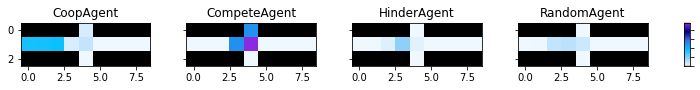

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

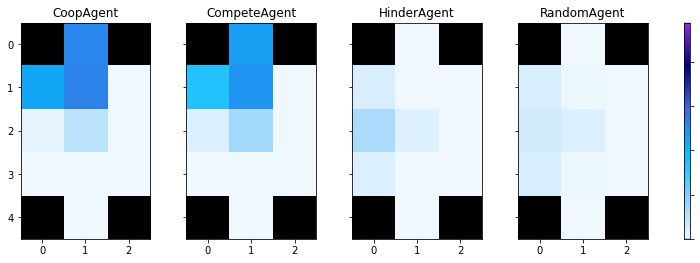

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Testing Cooperative Sequence
grid1 = Grid([0, 1], [9, 10], 11, [4, 6], cell_transition_grid1)
grid2 = Grid([0], [10], 11, [4, 6], cell_transition_grid2)
cell_to_index_fn = [cell_to_row_col_pair1, cell_to_row_col_pair2]
grid_dims = [(3, 9), (5, 3)]

for g, grid in enumerate([grid1, grid2]):

  coop = CoopAgent(grid, 4, 0.5)
  compete = CompeteAgent(grid, 4)
  hinder = HinderAgent(grid, 4)
  randAgent = RandomAgent(grid)

  # Train.
  coop.train('Blue')
  compete.train('Blue')
  hinder.train('Blue', p=3)
  randAgent.update_pi('Blue')

  coop.train('Yellow')
  compete.train('Yellow')
  hinder.train('Yellow', p=3)
  randAgent.update_pi('Yellow')

  state_size = grid.num_cells

  viz_matricies = []
  titles = []
  for agent, ax in [(coop, axs[0,0]), (compete, axs[0,1]), (hinder, axs[1,0]), (randAgent, axs[1,1])]:
    viz_matrix = np.zeros(grid_dims[g])
    viz_matrix[:] = -10
    for s in range(0, 11):
      r,c = cell_to_index_fn[g](s)
      viz_matrix[r][c] = 0.0

    '''
    # pi dictionary, self.pi[state][(a1, a2)] = P(a1, a2 | s)
    # q dictionary, self.q[state][action_pair] = value
    '''

    # play game many times
    for _ in range(10000):
      state = start_state
      prior = 1
      iters = 0
      while iters < 50 and None not in state and state[0] not in grid.blue_reward_cells and state[1] not in grid.yellow_reward_cells:
        best_action_blue = agent.get_action(state, 'Blue')[0]
        best_action_yellow = agent.get_action(state, 'Yellow')[0]
        s0, s1, collide = grid.state_transition(state, best_action_blue, best_action_yellow)
        
        action_index = actions.index(best_action_blue)
        posterior = agent.pi_blue[state][action_index] * prior
        state = (s0, s1)

        viz_matrix[cell_to_index_fn[g](s0)] += posterior
        prior = posterior
        iters += 1
    
    viz_matricies.append(viz_matrix)
    titles.append(type(agent).__name__)

  visualize(viz_matricies, titles, "Low Level Agent Pi Heatmaps", "heatmapsG" + str(g) + ".png")


# High Level CCAgent

In [ ]:
# High Level CCAgent, playing a 'tit for tat' game
class CCAgent:
  def __init__(self, 
               coop_agent,
               comp_agent,
               grid, # object: instance of grid class 
               data, # list of (state, (action tuple)) describing a single game
               b,
               decay):
    
    self.actions = ["RIGHT", "LEFT", "UP", "DOWN", "WAIT"]
    self.coop_agent = coop_agent 
    self.comp_agent = comp_agent
    self.grid = grid
    self.coop_prior = 0.5 # Initially, no preference for Coop or Comp
    self.data = data
     
    # 'As decay approaches 0 from the left, the agent is more likely to remain in the same mode as its prior.
    #  As decay approaches 1 from the right, the agent is more likely to switch between low-level modes'
    self.d = decay
    # 'To create a generous model that always has some probability of switching, we bound 𝑃(𝐶𝑖+1) by [𝑏, 1 − 𝑏] where 0 ≤ 𝑏 ≤ 0.5. '
    self.b = b

  # Run though
  def observe(self, player):

    for i, d_i in enumerate(self.data):
      state, action_pair = d_i
      if None not in action_pair:
        print(self.coop_prior)
        self.coop_prior = min(max(self.coop_prior, self.b), 1 - self.b)
        print(self.coop_prior)
        comp_prior = 1 - self.coop_prior

        T_coop = (1 - self.d) * self.coop_prior + self.d * comp_prior 
        T_comp = (self.d) * self.coop_prior + (1 - self.d) * comp_prior 

        if player == "Blue":
          action_index = self.actions.index(action_pair[0]) # get blue's action
          likelihood_coop = self.coop_agent.pi_blue[state][action_index]
          likelihood_comp = self.comp_agent.pi_blue[state][action_index]
        elif player == "Yellow":
          action_index = self.actions.index(action_pair[1]) # get yellow's action
          likelihood_coop = self.coop_agent.pi_yellow[state][action_index]
          likelihood_comp = self.comp_agent.pi_yellow[state][action_index]

        posterior_coop = likelihood_coop * T_coop
        posterior_comp = likelihood_comp * T_comp

        b_weight = (1 - 2*self.b)
        pi_weighted = (T_coop*b_weight + self.b)*likelihood_coop + (T_comp*b_weight + self.b)*likelihood_comp 

        self.coop_prior = pi_weighted 

        print("TIME STEP ", i)
        print("OBSERVED STATE: ", state)
        print("OBSERVED ACTION PAIR: ", action_pair)
        print("T_coop: ", T_coop)
        print("T_comp: ", T_comp)
        print("likelihood_coop: ", likelihood_coop)
        print("likelihood_comp: ", likelihood_comp)
        print("posterior_coop: ", posterior_coop)
        print("posterior_comp: ", posterior_comp)
        print("pi weighted: ", pi_weighted)
        print()

  


In [ ]:
# Testing Cooperative Sequence
grid1 = Grid([0, 1], [9, 10], 11, [4, 6], cell_transition_grid1)
data = [((4,6), ('LEFT', 'RIGHT')), ((3, 7), ('LEFT', 'RIGHT')), ((2, 8), ('LEFT', 'RIGHT')), ((1, 9), (None, None))]
coop = CoopAgent(grid1, 4, 0.5)
compete = CompeteAgent(grid1, 4)

'''
grid2 = Grid([0], [10], 11, [4, 6], cell_transition_grid2)
data2 = [((4,6), ('UP', 'DOWN')), ((1,9), ('RIGHT', 'LEFT')), ((2, 8), ('UP', 'DOWN')), ((0, 10), (None, None))]
coop = CoopAgent(grid2, 4, 0.5)
compete = CompeteAgent(grid2, 4)
'''

# Train.
coop.train('Yellow')
compete.train('Yellow')
b = 0.25
decay = 0.159

agent = CCAgent(coop, compete, grid1, data, b, decay)

print(agent.observe("Yellow"))

In [ ]:
# Testing Competitive Sequence
grid1 = Grid([0, 1], [9, 10], 11, [4, 6], cell_transition_grid1)
data = [((4,6), ('RIGHT', 'LEFT')), ((4, 5), ('RIGHT', 'DOWN')), ((5, 10), (None, None))]

coop = CoopAgent(grid1, 4, 0.5)
compete = CompeteAgent(grid1, 4)

# Train
coop.train('Yellow')
compete.train('Yellow')
beta = 4.04
decay = 0.159
agent = CCAgent(coop, compete, grid1, data, beta, decay)

print(agent.observe('Yellow'))

# High Level SuperGeneralAgent

In [ ]:
# High Level DirAgent
class SuperGeneralAgent:
  def __init__(self, 
               agents, # list of all low level agents
               grid, # object: instance of grid class 
               decay,
               diff,
               priors=None,
               last_state=None):
    
    self.actions = ["RIGHT", "LEFT", "UP", "DOWN", "WAIT"]
    self.agents = agents
    self.grid = grid
    # 'As decay approaches 0 from the left, the agent is more likely to remain in the same mode as its prior.
    #  As decay approaches 1 from the right, the agent is more likely to switch between low-level modes'
    self.d = decay
    self.diff = diff

    self.priors = [1.0/len(self.agents) for _ in self.agents] if priors == None else priors
    self.last_state = last_state
    self.last_strategy = None
    self.won_last_game = False


  # Run though
  def observe(self, 
              player,
              data, # list of (state, (action tuple)) describing a single game
              verbose=False):

    for i, d_i in enumerate(data):
      state, action_pair = d_i
      self.last_state = state
      if None not in action_pair:
        T = [(1-self.d)*p + self.d*(sum(self.priors) - p) for p in self.priors]

        if player == "Blue":
          action_index = self.actions.index(action_pair[0]) # get blue's action
          if verbose: print("ACTION INDEX: ", action_index)
          likelihoods = [a.pi_blue[state][action_index] if action_index < len(a.pi_blue[state]) else 0 for a in self.agents]
        elif player == "Yellow":
          action_index = self.actions.index(action_pair[1]) # get yellow's action
          if verbose: print("ACTION INDEX: ", action_index)
          likelihoods = [a.pi_yellow[state][action_index] if action_index < len(a.pi_yellow[state]) else 0 for a in self.agents]
        
        posteriors = [likelihoods[i] * T[i] for i in range(0, len(self.agents))]
        if verbose:
          print('FIRST POSTERIOR', posteriors)
        for j in range(len(posteriors)):
          if abs(posteriors[j] - self.priors[j]) > self.diff:
            if posteriors[j] > self.priors[j]:
              posteriors[j] -= self.diff
            else:
              posteriors[j] += self.diff

        self.priors = [p / sum(posteriors) for p in posteriors]

        if verbose:
          print("TIME STEP ", i)
          print("Agents: ", self.agents)
          print("OBSERVED STATE: ", state)
          print("OBSERVED ACTION PAIR: ", action_pair)
          print("T: ", T)
          print("likelihoods: ", likelihoods)
          print("posteriors: ", posteriors)
          print("normalized posteriors: ", self.priors)
          print()
        
      b_won = self.last_state[0] in self.grid.blue_reward_cells
      y_won = self.last_state[1] in self.grid.yellow_reward_cells
      if b_won or y_won:
        # player = observed opponent
        if player == "Blue": self.won_last_game = y_won 
        if player == "Yellow": self.won_last_game = b_won 


  def next_action(self, player, my_agents, verbose=False):
    max_prior = max(self.priors)
    if verbose: print(self.last_state)
    # 2. Obtain all actions from agents that have the max prior (this accounts for agents that are tied-for-first)
    action_options = {type(a).__name__: (a, a.get_action(self.last_state, player)[0]) for i, a in enumerate(my_agents) if self.priors[i] == max_prior}
    # 3. The probability of choosing any one action of the max agents is 1/(# actions)
    probs = [1.0 / len(action_options) for _ in range(len(action_options))]
    if verbose: print("action_options: ", action_options)
    if verbose: print("probs: ", probs)
    
    choice = np.random.choice([k for k in action_options.keys()], 1, p=probs)[0]
    self.last_strategy = action_options[choice][0]
    if verbose: print("Chosen strategy: ", self.last_strategy)
    move = action_options[choice][1]
    if verbose: print("Chosen move: ", move)
    return move, choice, max_prior
  
  '''
  Note: Agents must have the same order as self.agents!
  '''
  def next_action_bayesian(self, player, my_agents, verbose=False):
    if verbose: print("Bayesian choice: " + str(self.priors))
    choice = np.random.choice(my_agents, 1, p=self.priors)[0]
    self.last_strategy = choice
    if verbose: print("Chosen strategy: ", self.last_strategy)
    move = choice.get_action(self.last_state, player)[0]
    if verbose: print("Chosen move: ", move)
    return move, choice, self.priors[my_agents.index(choice)]
  
  def prior_for(self, agent_type):
    for i, agent in enumerate(self.agents):
      if type(agent) == agent_type:
        return self.priors[i]
    return 0
  
  def next_action_pavlovian(self, player, my_agents, verbose=False):
    if self.won_last_game:
      if verbose: print("Keeping last strategy's (winning) strategy.")
      choice = self.last_strategy
      move = choice.get_action(self.last_state,  player)[0]
      prior = self.prior_for(type(choice))
      return choice, move, prior
    else:
      if verbose: print("I lost last, so I'll change up my strategy.")
      return self.next_action(player, my_agents, verbose)

  


In [ ]:
# Testing Cooperative Sequence
grid1 = Grid([0, 1], [9, 10], 11, [4, 6], cell_transition_grid1)
data = [((4,6), ('LEFT', 'RIGHT')), ((3, 7), ('LEFT', 'RIGHT')), ((2, 8), ('LEFT', 'RIGHT')), ((1, 9), (None, None))]
coop = CoopAgent(grid1, 4, 0.5)
compete = CompeteAgent(grid1, 4)
hinder = HinderAgent(grid1, 4)
randAgent = RandomAgent(grid1)

'''
grid2 = Grid([0], [10], 11, [4, 6], cell_transition_grid2)
data2 = [((4,6), ('UP', 'DOWN')), ((1,9), ('RIGHT', 'LEFT')), ((2, 8), ('UP', 'DOWN')), ((0, 10), (None, None))]
coop = CoopAgent(grid2, 4, 0.5)
compete = CompeteAgent(grid2, 4)
'''

# Train
coop.train('Yellow')
compete.train('Yellow')
hinder.train('Yellow', p=3)
randAgent.update_pi('Yellow')
b = 0.25
decay = 0.159

agent = SuperGeneralAgent([coop, compete, hinder, randAgent], grid1, b, decay)

print(agent.observe("Yellow", data))

In [ ]:
# Testing Competitive Sequence
grid1 = Grid([0, 1], [9, 10], 11, [4, 6], cell_transition_grid1)
data = [((4,6), ('RIGHT', 'LEFT')), ((4, 5), ('RIGHT', 'DOWN')), ((5, 10), (None, None))]

coop = CoopAgent(grid1, 4, 0.5)
compete = CompeteAgent(grid1, 4)

# Train
coop.train('Yellow')
compete.train('Yellow')
hinder.train('Yellow', p=3)
randAgent.update_pi('Yellow')
b = 0.25
decay = 0.159

agent = SuperGeneralAgent([coop, compete, hinder, randAgent], grid1, b, decay)

print(agent.observe("Yellow", data))

In [ ]:
# Testing Hindering Sequence
grid2 = Grid([0], [10], 11, [4, 6], cell_transition_grid2)
hinder = HinderAgent(grid2, 4)
compete = CompeteAgent(grid2, 4)
coop = CoopAgent(grid2, 4, 0.5)
randAgent = RandomAgent(grid2)

# Train
hinder.train('Yellow', p=3)
compete.train('Yellow')
coop.train('Yellow')
randAgent.update_pi('Yellow')

# cooperative sequence
data = [((4,6), ('UP', 'DOWN')), ((1,9), ('RIGHT', 'LEFT')), ((2, 8), ('UP', 'DOWN')), ((0, 10), (None, None))]

# hindering sequence
data2 = [((4,6), ('WAIT', 'UP')), ((4,3), ('UP', 'LEFT')), ((1, 2), ('RIGHT', 'WAIT'))]

b = 0.25
decay = 0.159

agent = SuperGeneralAgent([coop, compete, hinder, randAgent], grid2, b, decay)
print(agent.observe("Yellow", data2))

# High Level GeneralAgent

In [ ]:
# High Level General Agent, takes any two lower level agents and computes posterior
class HLAgent:
  def __init__(self, 
               agent_1, # trained agent instance
               agent_1_name, # str: agent name 
               agent_2, # trained agent instance
               agent_2_name, # str: agent name
               grid, # object: instance of grid class 
               b,
               decay,
               starting_state=None):
    
    self.actions = ["RIGHT", "LEFT", "UP", "DOWN", "WAIT"]
    self.agent_1 = agent_1
    self.agent_2 = agent_2
    self.agent1_name = agent_1_name
    self.agent2_name = agent_2_name
    self.grid = grid
    self.agent1_prior = 0.5 # Initially, no preference for Coop or Comp
     
    # 'As decay approaches 0 from the left, the agent is more likely to remain in the same mode as its prior.
    #  As decay approaches 1 from the right, the agent is more likely to switch between low-level modes'
    self.d = decay
    # 'To create a generous model that always has some probability of switching, we bound 𝑃(𝐶𝑖+1) by [𝑏, 1 − 𝑏] where 0 ≤ 𝑏 ≤ 0.5. '
    self.b = b

    self.last_state = starting_state

  # Run though
  def observe(self, 
              player, # str : "Blue" or "Yellow"
              data): # list of (state, (action tuple)) describing a single game):

    for i, d_i in enumerate(data):
      state, action_pair = d_i
      if None not in action_pair:
        # bound the agent1 prior by [b, 1-b]
        self.agent1_prior = min(max(self.agent1_prior, self.b), 1 - self.b)
        agent2_prior = 1 - self.agent1_prior

        T_agent1 = (1 - self.d) * self.agent1_prior + self.d * agent2_prior
        T_agent2 = (self.d) * self.agent1_prior + (1 - self.d) * agent2_prior

        if player == "Blue":
          action_index = self.actions.index(action_pair[0]) # get blue's action
          likelihood_agent1 = self.agent_1.pi_blue[state][action_index]
          likelihood_agent2 = self.agent_2.pi_blue[state][action_index]
        elif player == "Yellow":
          action_index = self.actions.index(action_pair[1]) # get yellow's action
          likelihood_agent1 = self.agent_1.pi_yellow[state][action_index]
          likelihood_agent2 = self.agent_2.pi_yellow[state][action_index]

        posterior_coop = likelihood_agent1 * T_agent1
        posterior_comp = likelihood_agent2 * T_agent2

        b_weight = (1 - 2*self.b)
        pi_weighted = (self.agent1_prior*b_weight + self.b)*likelihood_agent1 + (agent2_prior*b_weight + self.b)*likelihood_agent2

        self.agent1_prior = pi_weighted # ??
        self.last_state = state

        print("TIME STEP ", i)
        print("OBSERVED STATE: ", state)
        print("OBSERVED ACTION PAIR: ", action_pair)
        print(f"likelihood_{self.agent1_name}: ", likelihood_agent1)
        print(f"likelihood_{self.agent2_name}: ", likelihood_agent2)
        print(f"posterior_{self.agent1_name}: ", posterior_coop)
        print(f"posterior_{self.agent2_name}: ", posterior_comp)
        print("pi weighted: ", pi_weighted)
  
  def next_action(self, player, my_agent_1, my_agent_2):
    a1 = my_agent_1.get_action(self.last_state, player)[0]
    a2 = my_agent_2.get_action(self.last_state, player)[0]

    if self.agent1_prior > 0.5:
      return a1, self.agent1_name, self.agent1_prior
    elif self.agent1_prior < 0.5:
      return a2, self.agent2_name, 1 - self.agent1_prior
    else:
      choice = np.random.choice([self.agent1_name, self.agent2_name], 1, p=[0.5, 0.5])[0]
      if choice == self.agent1_name:
        return a1, choice, 0.5
      else:
        return a2, choice, 0.5



In [ ]:
# Testing Hinder/Compete on Grid2
grid2 = Grid([0], [10], 11, [4, 6], cell_transition_grid2)
hinder = HinderAgent(grid2, 4)
compete = CompeteAgent(grid2, 4)
beta = 4.04
decay = 0.159

# Train
hinder.train('Yellow', p=3)
compete.train('Yellow')

# cooperative sequence
data = [((4,6), ('UP', 'DOWN')), ((1,9), ('RIGHT', 'LEFT')), ((2, 8), ('UP', 'DOWN')), ((0, 10), (None, None))]

# hindering sequence
data2 = [((4,6), ('WAIT', 'UP')), ((4,3), ('UP', 'LEFT')), ((1, 2), ('RIGHT', 'WAIT'))]

agent = HLAgent(hinder, 'Hinder', compete, 'Compete', grid2, beta, decay)

print('Cooperative Sequence Predictions')
print(agent.observe('Yellow', data), '\n')

print('Hindering Sequence Predictions')
print(agent.observe('Yellow', data2), '\n')

# High Level ForgetfulAgent

In [ ]:
# High Level RandomAgent
import random
class ForgetfulAgent:
  def __init__(self, 
               agents,
               grid, # object: instance of grid class 
               start_state
               ):
    
    self.actions = ["RIGHT", "LEFT", "UP", "DOWN", "WAIT"]
    self.agents = agents
    self.grid = grid
    self.priors = [1.0/len(self.agents)] * len(self.agents)
    self.last_state = start_state

  # Run though
  def observe(self, 
              player,
              data, # list of (state, (action tuple)) describing a single game
              verbose=False):

    for i, d_i in enumerate(data):
      state, action_pair = d_i
      if None not in action_pair:
        if player == "Blue":
          action_index = self.actions.index(action_pair[0]) # get blue's action
          likelihoods = [a.pi_blue[state][action_index] if action_index < len(a.pi_blue[state]) else 0 for a in self.agents]
        elif player == "Yellow":
          action_index = self.actions.index(action_pair[1]) # get yellow's action
          likelihoods = [a.pi_yellow[state][action_index] if action_index < len(a.pi_yellow[state]) else 0 for a in self.agents]

        self.priors = likelihoods

        if verbose:
          print("TIME STEP ", i)
          print("Agents: ", self.agents)
          print("OBSERVED STATE: ", state)
          print("OBSERVED ACTION PAIR: ", action_pair)
          print("T: ", T)
          print("likelihoods: ", likelihoods)
          print("posteriors: ", posteriors)
          print("normalized posteriors: ", self.priors)
          print()
        self.last_state = state

  def next_action(self, player, my_agents, verbose=False):
    # 1. Find max prior
    max_prior = max(self.priors)
    # 2. Obtain all actions from agents that have the max prior
    # (this accounts for agents that are tied-for-first)
    action_options = {type(a).__name__: a.get_action(self.last_state, player)[0] for i, a in enumerate(my_agents) if self.priors[i] == max_prior}
    # 3. The probability of choosing any one action of the max
    # agents is 1/(# actions)
    probs = [1.0 / len(action_options) for _ in range(len(action_options))]
    if verbose: print("action_options: ", action_options)
    if verbose: print("probs: ", probs)
    choice = np.random.choice([k for k in action_options.keys()], 1, p=probs)[0]
    return action_options[choice], choice, max_prior
  
  def prior_for(self, agent_type):
    for i, agent in enumerate(self.agents):
      if type(agent) == agent_type:
        return self.priors[i]
    return 0


In [ ]:
# Testing Cooperative Sequence
grid1 = Grid([0, 1], [9, 10], 11, [4, 6], cell_transition_grid1)
data = [((4,6), ('LEFT', 'RIGHT')), ((3, 7), ('LEFT', 'RIGHT')), ((2, 8), ('LEFT', 'RIGHT')), ((1, 9), (None, None))]
coop = CoopAgent(grid1, 4, 0.5)
compete = CompeteAgent(grid1, 4)

# Train
coop.train('Yellow')
compete.train('Yellow')

agent = CluelessAgent(coop, compete, grid1, data)

print(agent.observe("Yellow"))

# Experiment 1


In [ ]:
# GRIDS
grid1 = Grid([0, 1], [9, 10], 11, [4, 6], cell_transition_grid1)
grid2 = Grid([0], [10], 11, [4, 6], cell_transition_grid2)

# AGENTS
coop1 = CoopAgent(grid1, 4, 0.5)
compete1 = CompeteAgent(grid1, 4)
hinder1 = HinderAgent(grid1, 4)
randAgent1 = RandomAgent(grid1)

coop2 = CoopAgent(grid2, 4, 0.5)
compete2 = CompeteAgent(grid2, 4)
hinder2 = HinderAgent(grid2, 4)
randAgent2 = RandomAgent(grid2)

# DATA
all_data = read_data()

# SUPER GENERAL AGENT
decay = 0.159
diff = 0.8

# AGENTS
all_agents = ["Coop", "Comp", "Hinder", "Random"]

predictions1_blue = []
predictions1_yellow = []
predictions2_blue = []
predictions2_yellow = []

for game in all_data:
  grid = game[1]
  data = game[0]
  if grid == 1:
    coop1.train('Blue', epsilon=.01)
    compete1.train('Blue', epsilon=.01)
    hinder1.train('Blue', p=3, epsilon=.01)
    randAgent1.update_pi('Blue')
    coop1.train('Yellow',epsilon=.01)
    compete1.train('Yellow',epsilon=.01)
    hinder1.train('Yellow', p=3,epsilon=.01)
    randAgent1.update_pi('Yellow')

    agent1 = SuperGeneralAgent([coop1, compete1, hinder1, randAgent1], grid1, decay, diff)

    agent1.observe("Blue", data)
    max_index_blue = agent1.priors.index(max(agent1.priors))
    predictions1_blue.append(all_agents[max_index_blue])

    agent1.observe("Yellow", data)
    max_index_yellow = agent1.priors.index(max(agent1.priors))
    predictions1_yellow.append(all_agents[max_index_yellow])
    
  elif grid == 2:
    coop2.train('Blue')
    compete2.train('Blue')
    hinder2.train('Blue', p=3)
    randAgent2.update_pi('Blue')
    coop2.train('Yellow')
    compete2.train('Yellow')
    hinder2.train('Yellow', p=3)
    randAgent2.update_pi('Yellow')

    agent2 = SuperGeneralAgent([coop2, compete2, hinder2, randAgent2], grid2, decay, diff)

    agent2.observe("Blue", data, verbose=True)
    max_index_blue = agent2.priors.index(max(agent2.priors))
    predictions2_blue.append(all_agents[max_index_blue])

    agent2.observe("Yellow", data)
    max_index_yellow = agent2.priors.index(max(agent2.priors))
    predictions2_yellow.append(all_agents[max_index_yellow])

for i in predictions1_blue:
  print(i)
print("_______")
for i in predictions1_yellow:
  print(i)
print("_______")
for i in predictions2_blue:
  print(i)
print("_______")
for i in predictions2_yellow:
  print(i)

# Experiment 2 (Attribution of Characteristic Sequences)

In [ ]:
# Tuning parameters
# Hinder Agent

# GRID 1
grid1 = Grid([0, 1], [9, 10], 11, [4, 6], cell_transition_grid1)
coop = CoopAgent(grid1, 4, 0.5)
compete = CompeteAgent(grid1, 4)
hinder = HinderAgent(grid1, 4)
randAgent = RandomAgent(grid1)


# Tune hinder variable
h1 = 0.5
h2 = 1
h3 = 3
h4 = 5
h5 = 10
hs = [h1, h2, h3, h4, h5]

# Train.
coop.train('Blue')
compete.train('Blue')
randAgent.update_pi('Blue')
b = 0.25
decay = 0.159
diff = 0.8

# Data 
data = [((4, 6), ('RIGHT', 'WAIT')), ((5, 6), ('WAIT', 'WAIT')), ((5, 6), ('WAIT', 'WAIT')), ((5, 6), ('WAIT', 'WAIT'))]

for h in hs:
  hinder.train('Blue', p=h)
  agent = SuperGeneralAgent([coop, compete, hinder, randAgent], grid1, decay, diff)
  print('Hinder param: ', h)
  agent.observe("Blue", data, verbose=True)





Hinder param:  0.5
ACTION INDEX:  0
TIME STEP  0
Agents:  [<__main__.CoopAgent object at 0x7fd096b41d68>, <__main__.CompeteAgent object at 0x7fd096a69b00>, <__main__.HinderAgent object at 0x7fd0a7772da0>, <__main__.RandomAgent object at 0x7fd096a69a58>]
OBSERVED STATE:  (4, 6)
OBSERVED ACTION PAIR:  ('RIGHT', 'WAIT')
T:  [0.25, 0.25, 0.25, 0.25]
likelihoods:  [0.19976048249577433, 0.9925967928127055, 0.9851340687237766, 0.2222222222222222]
posteriors:  [0.20894012062394357, 0.24814919820317638, 0.24628351718094416, 0.21455555555555555]
normalized posteriors:  [0.2276213728045064, 0.27033611824607967, 0.26830362743374714, 0.23373888151566688]

ACTION INDEX:  4
TIME STEP  1
Agents:  [<__main__.CoopAgent object at 0x7fd096b41d68>, <__main__.CompeteAgent object at 0x7fd096a69b00>, <__main__.HinderAgent object at 0x7fd0a7772da0>, <__main__.RandomAgent object at 0x7fd096a69a58>]
OBSERVED STATE:  (5, 6)
OBSERVED ACTION PAIR:  ('WAIT', 'WAIT')
T:  [0.2276213728045064, 0.27033611824607967, 0.26

In [ ]:
# Tuning Hinder

# GRID 2
grid2 = Grid([0], [10], 11, [4, 6], cell_transition_grid2)
coop = CoopAgent(grid2, 4, 0.5)
compete = CompeteAgent(grid2, 4)
hinder = HinderAgent(grid2, 4)
randAgent = RandomAgent(grid2)

# Tune hinder variable
h1 = 0.5
h2 = 1
h3 = 3
h4 = 5
h5 = 10
hs = [h1, h2, h3, h4, h5]

# Train.
coop.train('Blue')
compete.train('Blue')
randAgent.update_pi('Blue')
b = 0.25
decay = 0.159
diff = 0.8

data=[((4, 6), ('DOWN', 'WAIT')), ((7, 6), ('RIGHT', 'WAIT')), ((8, 6), ('WAIT', 'WAIT')), ((8, 6), ('WAIT', 'WAIT')), ((8, 6), ('WAIT', 'WAIT'))]

for h in hs:
  hinder.train('Blue', p=h)
  agent = SuperGeneralAgent([coop, compete, hinder, randAgent], grid2, decay, diff)
  print('Hinder param: ', h)
  print(agent.observe("Blue", data, verbose=True))

# CONCLUSION: Set h=3 as hinder value! 


Hinder param:  0.5
ACTION INDEX:  3
TIME STEP  0
Agents:  [<__main__.CoopAgent object at 0x7fd096da0ef0>, <__main__.CompeteAgent object at 0x7fd0a782e438>, <__main__.HinderAgent object at 0x7fd0a77a0240>, <__main__.RandomAgent object at 0x7fd096d7edd8>]
OBSERVED STATE:  (4, 6)
OBSERVED ACTION PAIR:  ('DOWN', 'WAIT')
T:  [0.25, 0.25, 0.25, 0.25]
likelihoods:  [0.0005135805294705128, 0.00022103295116151635, 3.565744712244254e-05, 0.16666666666666666]
posteriors:  [0.15912839513236762, 0.15905525823779038, 0.1590089143617806, 0.20066666666666666]
normalized posteriors:  [0.23475138650806446, 0.23464349258132297, 0.23457512458741211, 0.2960299963232006]

ACTION INDEX:  0
TIME STEP  1
Agents:  [<__main__.CoopAgent object at 0x7fd096da0ef0>, <__main__.CompeteAgent object at 0x7fd0a782e438>, <__main__.HinderAgent object at 0x7fd0a77a0240>, <__main__.RandomAgent object at 0x7fd096d7edd8>]
OBSERVED STATE:  (7, 6)
OBSERVED ACTION PAIR:  ('RIGHT', 'WAIT')
T:  [0.23475138650806446, 0.2346434925813

## Grid 1 Attribution

In [ ]:
# Grid 1 Attribution
grid1 = Grid([0, 1], [9, 10], 11, [4, 6], cell_transition_grid1)
coop = CoopAgent(grid1, 4, 0.5)
compete = CompeteAgent(grid1, 4)
hinder = HinderAgent(grid1, 4)
randAgent = RandomAgent(grid1)


# Train.
coop.train('Blue')
compete.train('Blue')
randAgent.update_pi('Blue')
hinder.train('Blue', p=3)
# random.train('Yellow')
b = 0.25
decay = 0.159
diff = 0.8

agent = SuperGeneralAgent([coop, compete, hinder, randAgent], grid1, decay, diff)

# Data 
data_coop = [((4, 6), ('LEFT', 'WAIT')), ((3, 6), ('LEFT', 'WAIT')), ((2, 6), ('LEFT', 'WAIT')), ((1, 6), (None, None))]
data_coop2 = [((4, 6), ('LEFT', 'RIGHT')), ((3, 7), ('LEFT', 'RIGHT')), ((2, 8), ('LEFT', 'RIGHT')), ((1, 9), (None, None))]
print('Coop Sequence Attribution')
agent.observe("Blue", data_coop, verbose=True)
#agent.observe("Blue", data_coop2, verbose=True)

data_comp = [((4, 6), ('RIGHT', 'WAIT')), ((5, 6), ('UP', 'WAIT')), ((0, 6), (None, None))]
data_comp2 = [((4, 6), ('RIGHT', 'LEFT')), ((5, 6), ('UP', 'LEFT')), ((0, 5), (None, None))]
print('Comp Sequence Attribution')
agent.observe("Blue", data_comp, verbose=True)
#agent.observe("Blue", data_comp2, verbose=True)

data_hinder = [((4, 6), ('RIGHT', 'WAIT')), ((5, 6), ('WAIT', 'WAIT')), ((5, 6), ('WAIT', 'WAIT')), ((5, 6), ('WAIT', 'WAIT'))]
data_hinder2 = [((4, 6), ('RIGHT', 'LEFT')), ((5, 6), ('WAIT', 'LEFT')), ((5, 6), ('WAIT', 'LEFT')), ((5, 6), ('WAIT', 'LEFT'))]
print('Hinder Sequence Attribution')
agent.observe("Blue", data_hinder, verbose=True)
#agent.observe("Blue", data_hinder2, verbose=True)

data_random = [((4, 6), ('LEFT', 'WAIT')), ((3, 6), ('LEFT', 'WAIT')), ((2, 6), ('RIGHT', 'WAIT')), ((3, 6), ('LEFT', 'WAIT')), ((2, 6), ('WAIT', 'WAIT'))]
data_random2 = [((4, 6), ('LEFT', 'RIGHT')), ((3, 7), ('LEFT', 'RIGHT')), ((2, 8), ('RIGHT', 'LEFT')), ((3, 7), ('LEFT', 'RIGHT')), ((2, 8), ('WAIT', 'WAIT'))]
print('Random Sequence Attribution')
agent.observe("Blue", data_random, verbose=True)
#agent.observe("Blue", data_random2, verbose=True)


Coop Sequence Attribution
ACTION INDEX:  1
FIRST POSTERIOR [0.14928245244261903, 0.00046270044920592254, 0.05002722247286399, 0.05555555555555555]
TIME STEP  0
Agents:  [<__main__.CoopAgent object at 0x7fd08e966eb8>, <__main__.CompeteAgent object at 0x7fd08ea8c908>, <__main__.HinderAgent object at 0x7fd0a77a0240>, <__main__.RandomAgent object at 0x7fd09753bd68>]
OBSERVED STATE:  (4, 6)
OBSERVED ACTION PAIR:  ('LEFT', 'RIGHT')
T:  [0.25, 0.25, 0.25, 0.25]
likelihoods:  [0.5971298097704761, 0.0018508017968236902, 0.20010888989145595, 0.2222222222222222]
posteriors:  [0.14928245244261903, 0.00046270044920592254, 0.05002722247286399, 0.05555555555555555]
normalized posteriors:  [0.5846694950473305, 0.0018121810940866234, 0.19593321534607483, 0.217585108512508]

ACTION INDEX:  1
FIRST POSTERIOR [0.5765152423972347, 0.0018032105495686239, 0.0391988612212906, 0.04835224633611289]
TIME STEP  1
Agents:  [<__main__.CoopAgent object at 0x7fd08e966eb8>, <__main__.CompeteAgent object at 0x7fd08ea8c

## Grid 2 Attribution

In [ ]:
# Grid 2 Attribution
grid1 = Grid([0], [10], 11, [4, 6], cell_transition_grid2)
coop = CoopAgent(grid2, 4, 0.5)
compete = CompeteAgent(grid2, 4)
hinder = HinderAgent(grid2, 4)
randAgent = RandomAgent(grid2)


# Train
coop.train('Blue')
compete.train('Blue')
randAgent.update_pi('Blue')
hinder.train('Blue', p=3)
b = 0.25
decay = 0.159
diff = 0.8

agent = SuperGeneralAgent([coop, compete, hinder, randAgent], grid2, decay, diff)

# Data 
data_coop = [((4, 6), ('UP', 'WAIT')), ((1, 6), ('RIGHT', 'WAIT')), \
             ((2, 6), ('WAIT', 'WAIT')), ((2, 6), ('WAIT', 'WAIT')), \
             ((2, 6), ('UP', 'WAIT')), ((0, 6), (None, None))]
print('Coop Sequence Attribution')
agent.observe("Blue", data_coop, verbose=True)

data_comp = [((4, 6), ('UP', 'WAIT')), ((1, 6), ('RIGHT', 'WAIT')), \
             ((2, 6), ('WAIT', 'WAIT')), ((0, 6), (None, None))]

print('Comp Sequence Attribution')
agent.observe("Blue", data_comp, verbose=True)

data_hinder = [((4, 6), ('DOWN', 'WAIT')), ((7, 6), ('RIGHT', 'WAIT')), \
               ((8, 6), ('WAIT', 'WAIT')), ((8, 6), ('WAIT', 'WAIT')), \
               ((8, 6), ('WAIT', 'WAIT'))]

print('Hinder Sequence Attribution')
agent.observe("Blue", data_hinder, verbose=True)

data_random = [((4, 6), ('DOWN', 'WAIT')), ((7, 6), ('UP', 'WAIT')), \
               ((4, 6), ('WAIT', 'WAIT')), ((4, 6), ('RIGHT', 'WAIT')), \
               ((5, 6), ('LEFT', 'WAIT')), ((4, 6), ('DOWN', 'WAIT')), \
               ((7, 6), ('WAIT', 'WAIT')), ((7, 6), ('UP', 'WAIT')), \
               ((4, 6), ('RIGHT', 'WAIT')), ((5, 6), ('WAIT', 'WAIT'))]

print('Random Sequence Attribution')
agent.observe("Blue", data_random, verbose=True)


Coop Sequence Attribution
ACTION INDEX:  2
FIRST POSTERIOR [0.16573310377031733, 0.14249106751311957, 0.049545826284209976, 0.041666666666666664]
TIME STEP  0
Agents:  [<__main__.CoopAgent object at 0x7fd08e966d30>, <__main__.CompeteAgent object at 0x7fd08e966e10>, <__main__.HinderAgent object at 0x7fd08e966e48>, <__main__.RandomAgent object at 0x7fd096da0a58>]
OBSERVED STATE:  (4, 6)
OBSERVED ACTION PAIR:  ('UP', 'WAIT')
T:  [0.25, 0.25, 0.25, 0.25]
likelihoods:  [0.6629324150812693, 0.5699642700524783, 0.1981833051368399, 0.16666666666666666]
posteriors:  [0.16573310377031733, 0.14249106751311957, 0.049545826284209976, 0.041666666666666664]
normalized posteriors:  [0.4149171035363359, 0.35673006579469346, 0.12403925508236742, 0.10431357558660306]

ACTION INDEX:  0
FIRST POSTERIOR [0.20635225059791082, 0.3556677109348653, 0.02491380974922553, 0.02318079457480068]
TIME STEP  1
Agents:  [<__main__.CoopAgent object at 0x7fd08e966d30>, <__main__.CompeteAgent object at 0x7fd08e966e10>, <__

# PYGame

## Model Game Play Setup

In [ ]:
def won(state, grid):
  # from perspective of BLUE player
  # returns: (win, tie, lost, inconclusive)
  if state[0] in grid.blue_reward_cells and state[1] in grid.yellow_reward_cells:
    return [0, 1, 0, 0]
  elif state[0] in grid.blue_reward_cells:
    return [1, 0, 0, 0]
  elif state[1] in grid.yellow_reward_cells:
    return [0, 0, 1, 0]
  else:
    return [0, 0, 0, 1]


## Model HL v L Game Play

In [ ]:
grid1 = Grid([0, 1], [9, 10], 11, [4, 6], cell_transition_grid1)
grid2 = Grid([0], [10], 11, [4, 6], cell_transition_grid2)
decay = 0.159


def get_trained_players(grid):
  '''
  Define Player 1
  '''
  coop1, hinder1, compete1, random1 = CoopAgent(grid, 4, 0.5), HinderAgent(grid, 5), CompeteAgent(grid, 4), RandomAgent(grid)
  yellow_agents = [coop1, compete1, hinder1, random1]

  coop1.train('Yellow')
  hinder1.train('Yellow', p=3)
  compete1.train('Yellow')
  random1.update_pi('Yellow')

  '''
  Define Player 2
  '''
  coop2, hinder2, compete2, random2 = CoopAgent(grid, 4, 0.5), HinderAgent(grid, 5), CompeteAgent(grid, 4), RandomAgent(grid)
  blue_agents = [coop2, compete2, hinder2, random2]

  coop2.train('Blue')
  hinder2.train('Blue', p=3)
  compete2.train('Blue')
  random2.update_pi('Blue')

  return (blue_agents, yellow_agents)

## HL Sequential Gameplay

In [ ]:
def play_game(HL_agent, opponent, next_move_fn):
  agent1_strategies = []
  agent1_assumed_agent2_strategies = []
  correct_confidences = []
  margin_of_confidences = []

  all_confidences = {type(a).__name__: [] for a in yellow_agents}

  state = (4, 6)
  states = []
  actions = []
  cutoff = 50
  while state[0] not in grid.blue_reward_cells and state[1] not in grid.yellow_reward_cells and len(states) < cutoff:
    sorted_priors = [HL_agent.prior_for(type(a2)) for a2 in yellow_agents if a2 != agent2]
    prior = HL_agent.prior_for(type(opponent))
    
    for a in yellow_agents:
      all_confidences[type(a).__name__].append(HL_agent.prior_for(type(a)))
    
    correct_confidences.append(prior)
    margin_of_confidences.append(prior - max(sorted_priors))

    # GET NEXT ACTION FROM THE AGENTS
    blue_action, assumed_strat0, prior0 = next_move_fn('Blue', blue_agents)
    yellow_action = opponent.get_action(state, 'Yellow')[0]
    
    agent1_assumed_agent2_strategies.append((assumed_strat0, prior0))
    agent1_strategies.append(assumed_strat0)

    # GET TRANSITION FROM THE GRID
    s0, s1, collide = grid.state_transition(state, blue_action, yellow_action)

    if s0 == state[0]: blue_action = 'WAIT' # observed action is WAIT
    if s1 == state[1]: yellow_action = 'WAIT'

    # AGENTS OBSERVE NEW DATA
    states.append(state)
    actions.append((blue_action, yellow_action))

    if not None in state:
      data = [(state, (blue_action, yellow_action))]
      HL_agent.observe('Yellow', data)
      state = (s0, s1)
    else:
      break

  HL_agent.observe('Yellow', [(state, (None, None))])
  return correct_confidences, len(states), won(state, grid), all_confidences, (states,  actions)


In [ ]:
def write_to_file(data, grid_id, agent1, agent2, filename):
  data_file = ""
  ground_truth = ""
  id = 0
  for run in data:
    states = run[0] #[r[0] for r in run]
    actions = run[1] # [r[1] for r in run]

    data_file += "ID: " + str(id) + "\n"
    data_file += "Grid: " + str(grid_id+1) + "\n"
    data_file += "Moves\n"
    data_file += "p0:" + str([s[0] for s in states]) + "\n"
    data_file += "p1:" + str([s[1] for s in states]) + "\n"
    data_file += "States\n"
    data_file += "p0:" + str([a[0] for a in actions]) + "\n"
    data_file += "p1:" + str([a[1] for a in actions]) + "\n"
    data_file += "\n"

    ground_truth += "ID: " + str(id) + "\n"
    ground_truth += "Blue Agent: " + str(type(agent1).__name__) + "\n"
    ground_truth += "Yellow Agent: " + str(type(agent2).__name__) + "\n"
    ground_truth += "\n"

    id += 1
      
  with open(filename + ".txt", 'w') as writefile:
    writefile.write(data_file)
    files.download(filename + ".txt")

  f_name = filename + '_ground_truth.txt'
  with open(f_name, 'w') as writefile:
    writefile.write(ground_truth)
    files.download(f_name)

GRID:  0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

OUTCOME BREAKDOWN for CoopAgent: [0.         0.6        0.36666667 0.03333333]
length of game mu,  std: (9.666666666666666, 12.7940958605479)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

OUTCOME BREAKDOWN for CompeteAgent: [0. 0. 1. 0.]
length of game mu,  std: (2.7333333333333334, 1.0306416555826872)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

OUTCOME BREAKDOWN for HinderAgent: [0.4 0.  0.  0.6]
length of game mu,  std: (37.333333333333336, 16.91416237621269)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

OUTCOME BREAKDOWN for RandomAgent: [0.36666667 0.         0.63333333 0.        ]
length of game mu,  std: (9.333333333333334, 8.202980488145078)


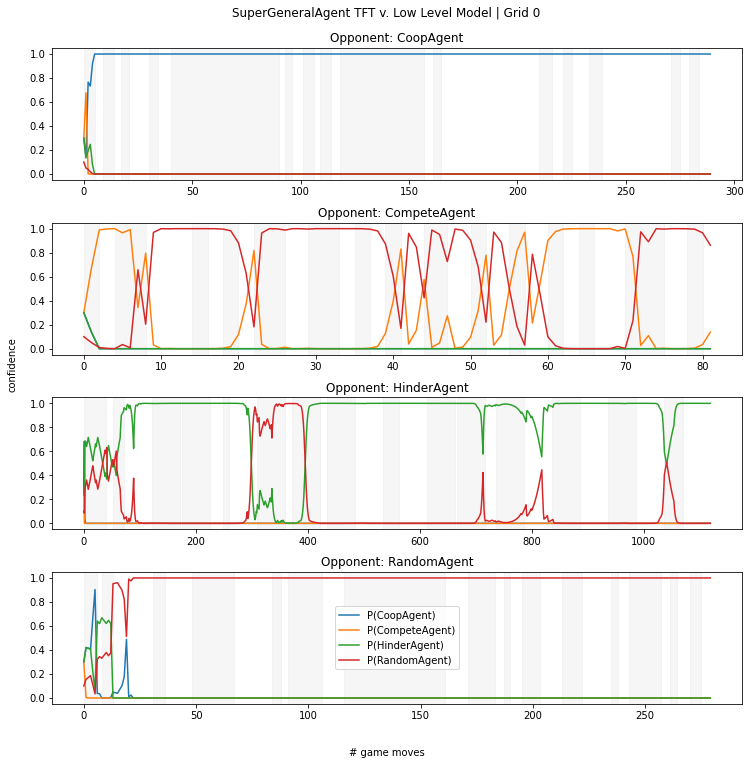

GRID:  1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

OUTCOME BREAKDOWN for CoopAgent: [0.03333333 0.23333333 0.73333333 0.        ]
length of game mu,  std: (4.866666666666666, 1.6878651868229553)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

OUTCOME BREAKDOWN for CompeteAgent: [0.         0.03333333 0.96666667 0.        ]
length of game mu,  std: (3.533333333333333, 0.618241233033047)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

OUTCOME BREAKDOWN for HinderAgent: [0.16666667 0.         0.         0.83333333]
length of game mu,  std: (45.6, 11.004847416782601)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

OUTCOME BREAKDOWN for RandomAgent: [0.06666667 0.03333333 0.56666667 0.33333333]
length of game mu,  std: (29.266666666666666, 16.76689860674564)


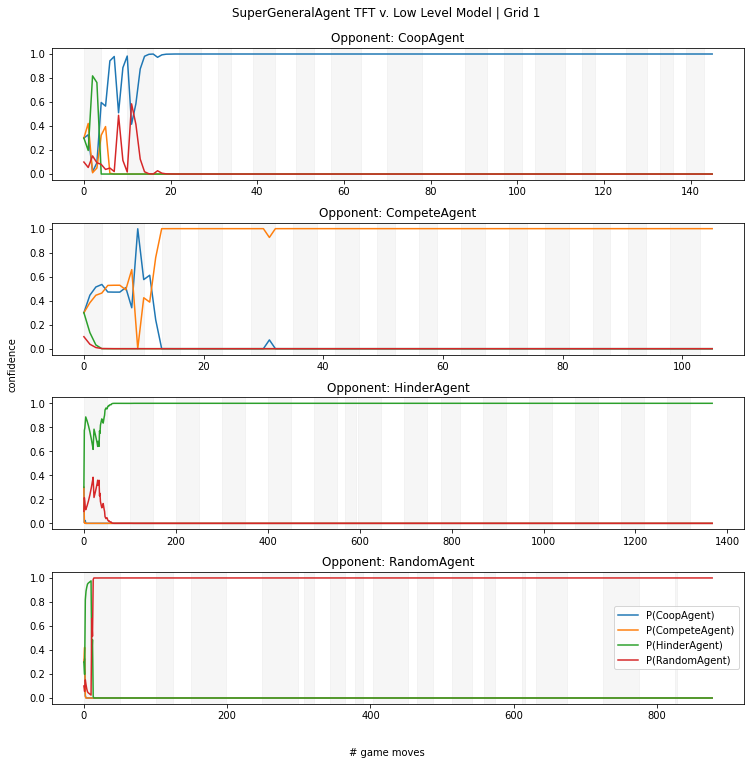

In [ ]:
'''
Seqeuntial Gameplay
'''
for grid_id, grid in enumerate([grid1, grid2]):
  print("GRID: ", grid_id)
  blue_agents, yellow_agents = get_trained_players(grid)
  '''
  Plots
  '''
  fig, axs = plt.subplots(4, 1, constrained_layout=True, figsize=(10, 10))
  fig.text(0.5, -0.04, '# game moves', ha='center', va='center')
  fig.text(-0.02, 0.5, 'confidence', ha='center', va='center', rotation='vertical')

  fig.suptitle("SuperGeneralAgent TFT v. Low Level Model | Grid " + str(grid_id))

  lines = []
  for agent_num, agent2 in enumerate(yellow_agents):
    confidence_matrix = []
    margin_of_confidence_matrix = []
    outcome_matrix = []
    length_vector = []
    all_priors = {type(a).__name__: [] for a in yellow_agents}

    decay=0 
    agent1 = SuperGeneralAgent(yellow_agents, grid, decay, 0.0, priors, (4,6))
    all_data = []
    for run in range(30):
      '''
      Play!!
      '''
      correct_cs, game_length, did_win, all_confidences, data = play_game(agent1, agent2, agent1.next_action)
      
      length_vector.append(game_length)
      outcome_matrix.append(did_win)
      confidence_matrix += correct_cs
      for p in all_priors.keys():
        all_priors[p] += all_confidences[p]
      all_data.append(data)
    
    write_to_file(all_data, grid_id, agent1, agent2, "HLvAGENT" + str(agent_num))
    
    '''
    Agent-specific statistics
    '''
    agent_name = str(type(agent2).__name__)
    collapsed = np.sum(np.array(outcome_matrix), axis=0)
    breakdown = collapsed / np.sum(collapsed)
    print("OUTCOME BREAKDOWN for " + agent_name + ": " + str(breakdown))
    
    length_mu = np.mean(np.array(length_vector), axis=0)
    length_sigma = np.std(np.array(length_vector), axis=0)
    print("length of game mu,  std: " + str((length_mu, length_sigma)))

    x = np.arange(0, sum(length_vector))

    axs[agent_num].set_title("Opponent: " + agent_name)
    for p in all_priors.keys():
      l, = axs[agent_num].plot(x, all_priors[p], label="P("+p+")")
      lines.append(l)
                   
    vx = 0
    for i in range(0, len(length_vector), 2):
      ms = length_vector[i]
      axs[agent_num].axvspan(vx, vx+ms, alpha=0.2, color='lightgray')
      vx += ms + length_vector[i+1]

  plt.legend(handles=lines[0:4])
  # plt.savefig("HL_pav2_" + str(grid_id) + ".png")
  plt.show()
  # files.download("HL_pav2_" + str(grid_id) + ".png") 

GRID:  0
I lost last, so I'll change up my strategy.
(4, 6)
action_options:  {'CoopAgent': (<__main__.CoopAgent object at 0x7f1af090d358>, 'LEFT'), 'CompeteAgent': (<__main__.CompeteAgent object at 0x7f1af10b4128>, 'RIGHT'), 'HinderAgent': (<__main__.HinderAgent object at 0x7f1af10b4240>, 'UP')}
probs:  [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
Chosen strategy:  <__main__.HinderAgent object at 0x7f1af10b4240>
Chosen move:  UP
I lost last, so I'll change up my strategy.
(4, 6)
action_options:  {'CoopAgent': (<__main__.CoopAgent object at 0x7f1af090d358>, 'LEFT')}
probs:  [1.0]
Chosen strategy:  <__main__.CoopAgent object at 0x7f1af090d358>
Chosen move:  LEFT
I lost last, so I'll change up my strategy.
(4, 6)
action_options:  {'CoopAgent': (<__main__.CoopAgent object at 0x7f1af090d358>, 'LEFT')}
probs:  [1.0]
Chosen strategy:  <__main__.CoopAgent object at 0x7f1af090d358>
Chosen move:  LEFT
I lost last, so I'll change up my strategy.
(3, 6)
action_options:  {'CoopAgent

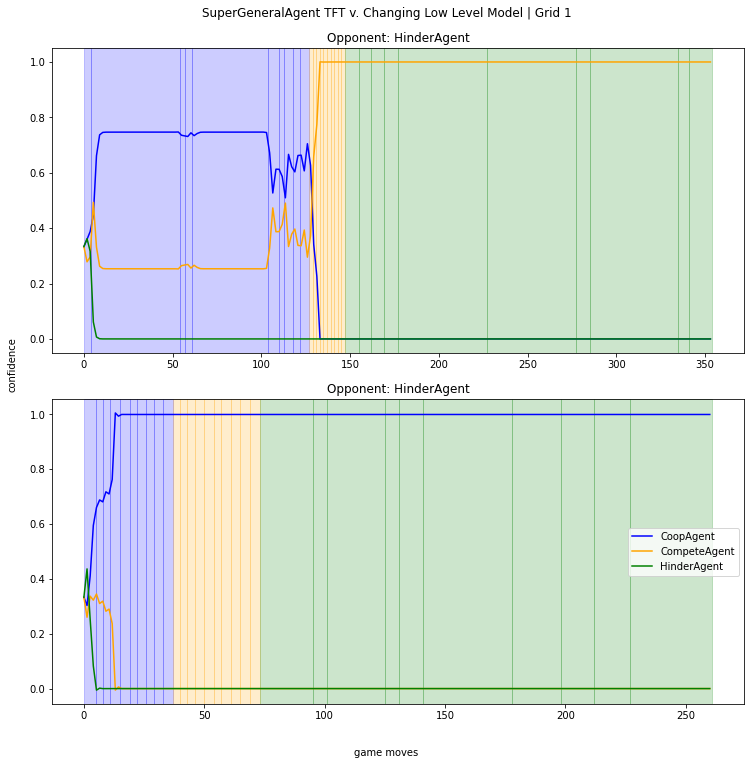

In [ ]:
from scipy.interpolate import make_interp_spline, BSpline
'''
SuperGeneralAgent Pavlovian v. Random mix
'''
color_dict = {'CoopAgent': "blue", 'CompeteAgent': "orange", 'HinderAgent': "green", 'RandomAgent': "red"}

'''
Plots
'''
fig, axs = plt.subplots(2, 1, constrained_layout=True, figsize=(10, 10))
fig.text(0.5, -0.04, 'game moves', ha='center', va='center')
fig.text(-0.02, 0.5, 'confidence', ha='center', va='center', rotation='vertical')

fig.suptitle("SuperGeneralAgent TFT v. Changing Low Level Model | Grid " + str(grid_id))

for grid_id, grid in enumerate([grid1, grid2]):
  print("GRID: ", grid_id)
  blue_agents, yellow_agents = get_trained_players(grid)
  # Testing -- No Random Agent
  blue_agents = [b for b in blue_agents if type(b) != RandomAgent]
  yellow_agents = [y for y in yellow_agents if type(y) != RandomAgent]

  lines = []
  confidence_matrix = []
  margin_of_confidence_matrix = []
  outcome_matrix = []
  length_vector = []
  color_vector = []
  all_priors = {type(a).__name__: [] for a in yellow_agents}

  decay=0.7 #159
  diff = 0.25
  agent1 = SuperGeneralAgent(yellow_agents, grid, decay, diff, (4,6))
  # np.random.shuffle(yellow_agents)
  for agent2 in yellow_agents:
    for run in range(10):
      correct_cs, game_length, did_win, all_confidences = play_game(agent1, agent2, agent1.next_action_pavlovian)
      
      length_vector.append(game_length)
      outcome_matrix.append(did_win)
      confidence_matrix += correct_cs
      for p in all_priors.keys():
        all_priors[p] += all_confidences[p]
      color_vector.append(color_dict[type(agent2).__name__])
    
  '''
  Agent-specific statistics
  '''
  agent_name = str(type(agent2).__name__)
  collapsed = np.sum(np.array(outcome_matrix), axis=0)
  breakdown = collapsed / np.sum(collapsed)
  print("OUTCOME BREAKDOWN for " + agent_name + ": " + str(breakdown))
  
  length_mu = np.mean(np.array(length_vector), axis=0)
  length_sigma = np.std(np.array(length_vector), axis=0)
  print("length of game mu,  std: " + str((length_mu, length_sigma)))

  x = np.arange(0, sum(length_vector))

  axs[grid_id].set_title("Opponent: " + agent_name)
  for p in all_priors.keys():
    xnew = np.linspace(x.min(), x.max(), 200) 
    spl = make_interp_spline(x, all_priors[p], k=3)
    y_smooth = spl(xnew)

    l, = axs[grid_id].plot(xnew, y_smooth, label=p, color=color_dict[p])
    lines.append(l)
                  
  vx = 0
  for clr, ms in zip(color_vector, length_vector):
    axs[grid_id].axvspan(vx, vx+ms, alpha=0.2, color=clr)
    vx += ms

plt.legend(handles=lines[0:4])
# plt.savefig("HL_mix_" + str(grid_id) + ".png")
plt.show()
# files.download("HL_mix_" + str(grid_id) + ".png") 

## Model Game L v L Play

In [ ]:
def play(blue, yellow, grid, num_games):
  games_data = []
  for run in range(num_games):
    '''
    Play!!
    '''
    state = (4, 6)
    data = []
    cutoff = 50
    while state[0] not in grid.blue_reward_cells and state[1] not in grid.yellow_reward_cells and len(data) < cutoff:
      # GET NEXT ACTION FROM THE AGENTS
      blue_action = blue.get_action(state, 'Blue')[0]
      yellow_action = yellow.get_action(state, 'Yellow')[0]

      # GET TRANSITION FROM THE GRID
      s0, s1, collide = grid.state_transition(state, blue_action, yellow_action)

      if s0 == state[0]: blue_action = 'WAIT' # observed action is WAIT
      if s1 == state[1]: yellow_action = 'WAIT'

      if not None in state:
        data.append((state, (blue_action, yellow_action)))
        state = (s0, s1)
      else:
        break
    games_data.append(data)
  return games_data

In [ ]:
def visualize_confidences(matrix, agent1_name, agent2_name, color, x_max, plots, i, j):
  x = np.linspace(0, 1, x_max)
  line = np.sum(np.array(matrix), axis=0)/len(matrix)
  l, = plots[i][j].plot(x, line, color=color)
  
  if i == 0: plots[i, j].set_title(agent2_name)
  if j == 0: plots[i, j].set_ylabel(agent1_name)
  return l

def pad_array(arr, to_length):
  arr += [arr[-1]] * (to_length-len(arr))
  return arr 

GRID:  0


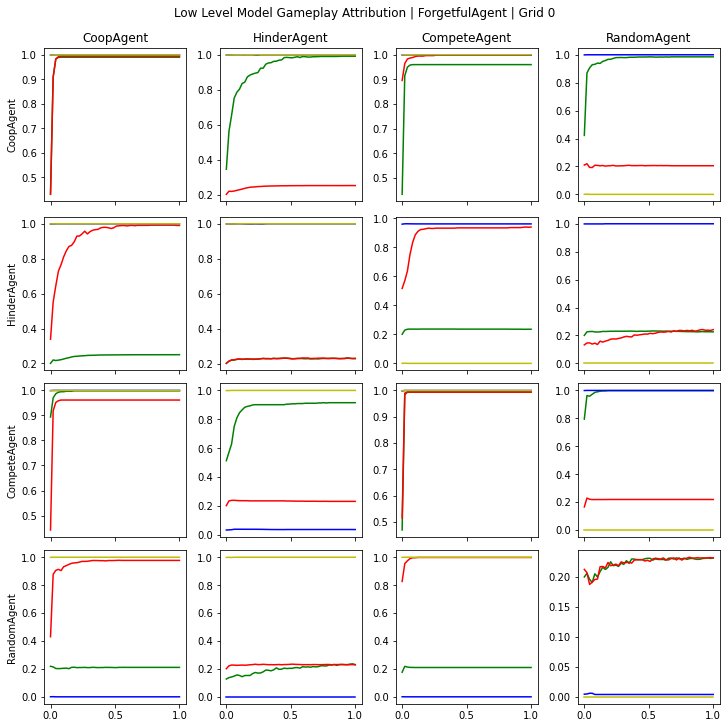

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

GRID:  1


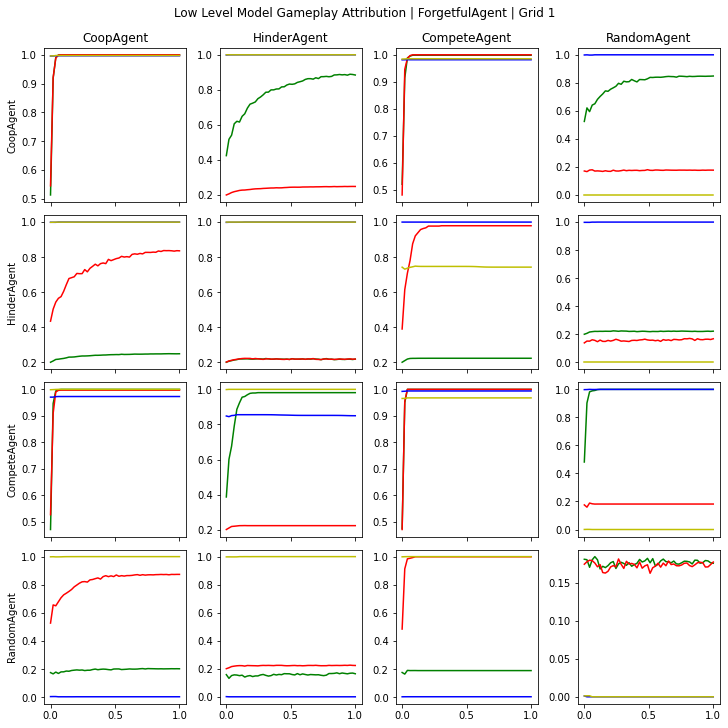

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
grid1 = Grid([0, 1], [9, 10], 11, [4, 6], cell_transition_grid1)
grid2 = Grid([0], [10], 11, [4, 6], cell_transition_grid2)
decay = 0.159

for grid_id, grid in enumerate([grid1, grid2]):
  print("GRID: ", grid_id)
  '''
  Define Player 1
  '''
  coop1, hinder1, compete1, random1 = CoopAgent(grid, 4, 0.5), HinderAgent(grid, 5), CompeteAgent(grid, 4), RandomAgent(grid)
  yellow_agents = [coop1, hinder1, compete1, random1]

  coop1.train('Yellow')
  hinder1.train('Yellow', p=3)
  compete1.train('Yellow')
  random1.update_pi('Yellow')

  '''
  Define Player 2
  '''
  coop2, hinder2, compete2, random2 = CoopAgent(grid, 4, 0.5), HinderAgent(grid, 5), CompeteAgent(grid, 4), RandomAgent(grid)
  blue_agents = [coop2, hinder2, compete2, random2]

  coop2.train('Blue')
  hinder2.train('Blue', p=3)
  compete2.train('Blue')
  random2.update_pi('Blue')

  fig, axs = plt.subplots(len(blue_agents), len(yellow_agents), constrained_layout=True, sharex=True, figsize=(10, 10))
  fig.suptitle("Low Level Model Gameplay Attribution | Grid " + str(grid_id))

  for i, agent1 in enumerate(blue_agents):
    for j, agent2 in enumerate(yellow_agents):
      agent1_title_name = type(agent1).__name__
      agent2_title_name = type(agent2).__name__
      data = play(agent1, agent2, grid, 500)
      data_dict[(agent1_name, agent2_name)] = data
      
      '''
      agent1 = SuperGeneralAgent(yellow_agents, grid, beta, decay, (4,6))
      get the super agent to observe each entry in the data matrix and make an attribution
      and run stats!
      '''
      HL_blue = SuperGeneralAgent(blue_agents, grid, decay, (4,6))
      HL_yellow = SuperGeneralAgent(yellow_agents, grid, decay, (4,6))
      HL_forget_blue = ForgetfulAgent(blue_agents, grid)
      HL_forget_yellow = ForgetfulAgent(yellow_agents, grid)

      confidence_matrix_blue = []
      confidence_matrix_yellow = []

      forget_confidence_matrix_blue = []
      forget_confidence_matrix_yellow = []

      for game in data:
        confidence_blue = []
        confidence_yellow = []

        forget_confidence_blue = []
        forget_confidence_yellow = []

        for move in game:
          HL_blue.observe('Blue', [move])
          HL_yellow.observe('Yellow', [move])

          confidence_blue.append(HL_blue.prior_for(type(agent1)))
          confidence_yellow.append(HL_yellow.prior_for(type(agent2)))

          HL_forget_blue.observe('Blue', [move])
          HL_forget_yellow.observe('Yellow', [move])

          forget_confidence_blue.append(HL_forget_blue.prior_for(type(agent1)))
          forget_confidence_yellow.append(HL_forget_yellow.prior_for(type(agent2)))
        
        pad_array(confidence_blue, 50)
        pad_array(confidence_yellow, 50)

        pad_array(forget_confidence_blue, 50)
        pad_array(forget_confidence_yellow, 50)

        confidence_matrix_blue.append(confidence_blue)
        confidence_matrix_yellow.append(confidence_yellow)

        forget_confidence_matrix_blue.append(forget_confidence_blue)
        forget_confidence_matrix_yellow.append(forget_confidence_yellow)
      
      visualize_confidences(forget_confidence_matrix_blue, "", "", 'g', 50, axs, i, j)
      visualize_confidences(forget_confidence_matrix_yellow, "", "", 'r', 50, axs, i, j)

      visualize_confidences(confidence_matrix_blue, agent1_title_name, agent2_title_name, 'b', 50, axs, i, j)
      visualize_confidences(confidence_matrix_yellow, agent1_title_name, agent2_title_name, 'y', 50, axs, i, j)

  plt.savefig("LL" + str(grid_id) + ".png")
  plt.show()
  files.download("LL" + str(grid_id) + ".png") 





In [ ]:
grid1 = Grid([0, 1], [9, 10], 11, [4, 6], cell_transition_grid1)
grid2 = Grid([0], [10], 11, [4, 6], cell_transition_grid2)
decay = 0.159

id = 1
data = ""
ground_truth = ""
for grid_id, grid in enumerate([grid1, grid2]):
  '''
  Define Player 1
  '''
  coop1, hinder1, compete1, random1 = CoopAgent(grid, 4, 0.5), HinderAgent(grid, 5), CompeteAgent(grid, 4), RandomAgent(grid)
  yellow_agents = [coop1, hinder1, compete1, random1]

  coop1.train('Yellow')
  hinder1.train('Yellow', p=3)
  compete1.train('Yellow')
  random1.update_pi('Yellow')

  '''
  Define Player 2
  '''
  coop2, hinder2, compete2, random2 = CoopAgent(grid, 4, 0.5), HinderAgent(grid, 5), CompeteAgent(grid, 4), RandomAgent(grid)
  blue_agents = [coop2, hinder2, compete2, random2]

  coop2.train('Blue')
  hinder2.train('Blue', p=3)
  compete2.train('Blue')
  random2.update_pi('Blue')

  for agent1 in blue_agents:
    for agent2 in yellow_agents:

      game = play(agent1, agent2, grid, 3)
      for run in game:
        states = [r[0] for r in run]
        actions = [r[1] for r in run]

        data += "ID: " + str(id) + "\n"
        data += "Grid: " + str(grid_id+1) + "\n"
        data += "Moves\n"
        data += "p0:" + str([s[0] for s in states]) + "\n"
        data += "p1:" + str([s[1] for s in states]) + "\n"
        data += "States\n"
        data += "p0:" + str([a[0] for a in actions]) + "\n"
        data += "p1:" + str([a[1] for a in actions]) + "\n"
        data += "\n"

        ground_truth += "ID: " + str(id) + "\n"
        ground_truth += "Blue Agent: " + str(type(agent1).__name__) + "\n"
        ground_truth += "Yellow Agent: " + str(type(agent2).__name__) + "\n"
        ground_truth += "\n"

        id += 1
      
with open('data_collection_LL.txt', 'w') as writefile:
  writefile.write(data)
  files.download('data_collection_LL.txt')

with open('data_collection_LL_ground_truth.txt', 'w') as writefile:
  writefile.write(ground_truth)
  files.download('data_collection_LL_ground_truth.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>